<p style="font-size:40px">Data cleaning and exploratory analysis</p> <br>

Pada jupyter notebook ini, akan ditunjukkan bagaimana dataset (https://archive.ics.uci.edu/ml/datasets/bank+marketing) dibersihkan, dimana di dalam dataset terdapat data yang berisikan <i>missing value</i> yang bernilai <i>unknown</i> dan <i>nonexistent</i>. Kemudian juga, akan dilanjutkan dengan <i>handling outlier</i> dan eksplorasi analisis secara statistik maupun visual, yang bertujuan untuk menghasilkan rekomendasi strategi-strategi yang seharusnya dilakukan oleh pihak bank.  

<b><p style="font-size:30px">Attribute Information:</p></b>

<b><p style="font-size:25px">Input Variable</p></b>

<p style="font-size:20px">Bank client data:</p>

* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')


<p style="font-size:20px">related with the last contact of the current campaign:</p>

* 8 - contact: contact communication type (categorical: 'cellular','telephone')
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

<p style="font-size:20px">other attributes:</p>

* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

<p style="font-size:20px">social and economic context attributes</p>

* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

<b><p style="font-size:25px">Output Variable</p></b>

* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as ss
from sklearn.neighbors import KernelDensity
from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import shapiro

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
bank = pd.read_csv('bank-additional-full.csv', sep = ';')
bank.drop('duration', axis = 1, inplace = True) #Berdasarkan dari dataset, dikatakan untuk membuat model realistis, kita harus membuatn fitur 'duration'

> <p style="font-family:'Courier New'">Hal pertama yang saya lakukan ke dataset adalah membuang fitur <i>duration</i>. Dimana dikutip dari datasetnya sendiri bahwa memasukkan fitur <i>duration</i> ke dalam model, membuat model menjadi tidak realistis (dimana saya berharap membuat model se-realistis mungkin). 
    
> <p style="font-family:'Courier New'">Di datasetnya sendiri juga mengatakan, jika <i> duration</i> = 0 maka y = 'no'. Itu kenapa, menjadi masuk akal membuang fitur duration membuat model menjadi lebih realistis. Karena jika tidak dibuang, artinya model akan sangat mudah membaca pola data dan memprediksi data. 

In [3]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
pd.DataFrame({'dataFeatures' : bank.columns, 'dataType' : bank.dtypes.values, 
              'null' : [bank[i].isna().sum() for i in bank.columns],
              'nullPct' : [((bank[i].isna().sum()/len(bank[i]))*100).round(2) for i in bank.columns],
             'Nunique' : [bank[i].nunique() for i in bank.columns],
             'uniqueSample' : [list(pd.Series(bank[i].unique()).sample(2)) for i in bank.columns]}).reset_index(drop = True)

,dataFeatures,dataType,null,nullPct,Nunique,uniqueSample
0,age,int64,0,0.0,78,"[67, 34]"
1,job,object,0,0.0,12,"[entrepreneur, unknown]"
2,marital,object,0,0.0,4,"[divorced, married]"
3,education,object,0,0.0,8,"[unknown, basic.6y]"
4,default,object,0,0.0,3,"[yes, no]"
5,housing,object,0,0.0,3,"[unknown, no]"
6,loan,object,0,0.0,3,"[yes, no]"
7,contact,object,0,0.0,2,"[cellular, telephone]"
8,month,object,0,0.0,10,"[apr, sep]"
9,day_of_week,object,0,0.0,5,"[fri, wed]"


> <p style="font-family:'Courier New'">Terlihat bahwa dataset tidak memperlihatkan adanya <i>missing value.</i> Namun dapat dilihat adanya fitur-fitur yang berisikan <i>unknown</i> dan <i> nonexistent </i>. Yang dimana telah disinggung sebelumnya, itu adalah <i>missing value</i> untuk dataset ini. 


In [186]:
# Fungsi-fungsi statistik yang akan digunakan pada notebook kali ini

#Correlation measurement untuk data kategorikal dan data numerikal
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

#Correlation measurement untuk data kategorikal dan kategorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Central Limit Theorem (Bootstrapping)
def clt(x):
    
    bank_yes = bank[bank['y']=='yes'][x]
    bank_no = bank[bank['y']=='no'][x]
    
    mean_yes = []
    mean_no = []
    
    for i in range(1000):
        mean_yes.append(bank_yes.sample(len(bank_yes), replace = True).mean())
        mean_no.append(bank_no.sample(len(bank_no), replace = True).mean())   
    
    #Confidence level = 0.95, significance level = 0.05
    bank_yes_lower = np.percentile(mean_yes, 25)
    bank_yes_upper = np.percentile(mean_yes, 75)
    bank_no_lower = np.percentile(mean_no, 25)
    bank_no_upper = np.percentile(mean_no, 75)
    
    fig = plt.figure(figsize = (15,5))
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Bootstrap distribution of the mean ({})'.format(x))    
        
    txt_yes_lower = str(round(bank_yes_lower,2))
    txt_yes_upper = str(round(bank_yes_upper,2))
    txt_no_lower = str(round(bank_no_lower,2))
    txt_no_upper = str(round(bank_no_upper,2))
    
    #membuat garis conf.level
    ax.axvline(bank_yes_lower, linestyle = '--')
    ax.axvline(bank_yes_upper, linestyle = '--')
    ax.axvline(bank_no_lower, c = 'red',  linestyle = '--')
    ax.axvline(bank_no_upper, c = 'red', linestyle = '--')
    
    #membuat Text    
    ax.text(bank_yes_lower, .7, ha='center', va='center', rotation = 'vertical', s = txt_yes_lower,
            backgroundcolor='white')
    ax.text(bank_yes_upper, .7, ha='center', va='center', rotation = 'vertical', s = txt_yes_upper,
            backgroundcolor='white')
    ax.text(bank_no_lower, .7, ha='center', va='center', rotation = 'vertical', s = txt_no_lower,
            backgroundcolor='white')
    ax.text(bank_no_upper, .7, ha='center', va='center', rotation = 'vertical', s = txt_no_upper,
           backgroundcolor='white')

    
    sns.distplot(mean_yes, hist = False, label = 'yes', ax = ax)   
    sns.distplot(mean_no, hist = False, label = 'no', color = 'red', ax = ax)
    
# mengukur probabilitas disuatu distribusi 
def get_probability(start_value, end_value, eval_points, kd):
    
    # Number of evaluation points 
    N = eval_points                                      
    step = (end_value - start_value) / (N - 1)  # Step size

    x = np.linspace(start_value, end_value, N)[:, np.newaxis]  # Generate values in the range
    kd_vals = np.exp(kd.score_samples(x))  # Get PDF values for each x
    probability = np.sum(kd_vals * step)  # Approximate the integral of the PDF
    return probability.round(4)

In [6]:
catData = bank.select_dtypes(exclude = np.number).columns
catData

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'], dtype='object')

# Handling Missing Value

> <p style="font-family:'Courier New'">Di dataset ini, <i>unknown</i> dan <i>nonexistent</i> adalah sebuah <i>missing value</i>. Strategi pertama yang saya lakukan adalah dengan mencoba mengisi <i>missing value</i> suatu fitur dengan melihat korelasi antar fitur lainnya. Kemudian mengisi <i>missing value</i> tersebut tergantung dari pola yang saya lihat. Namun jika misalnya, tidak ada pola yang dapat saya lihat. Maka saya akan cek korelasi fitur itu dengan fitur target (jika sangat lemah, kemungkinan saya akan hapus) atau melakukan tes signifikansi. 

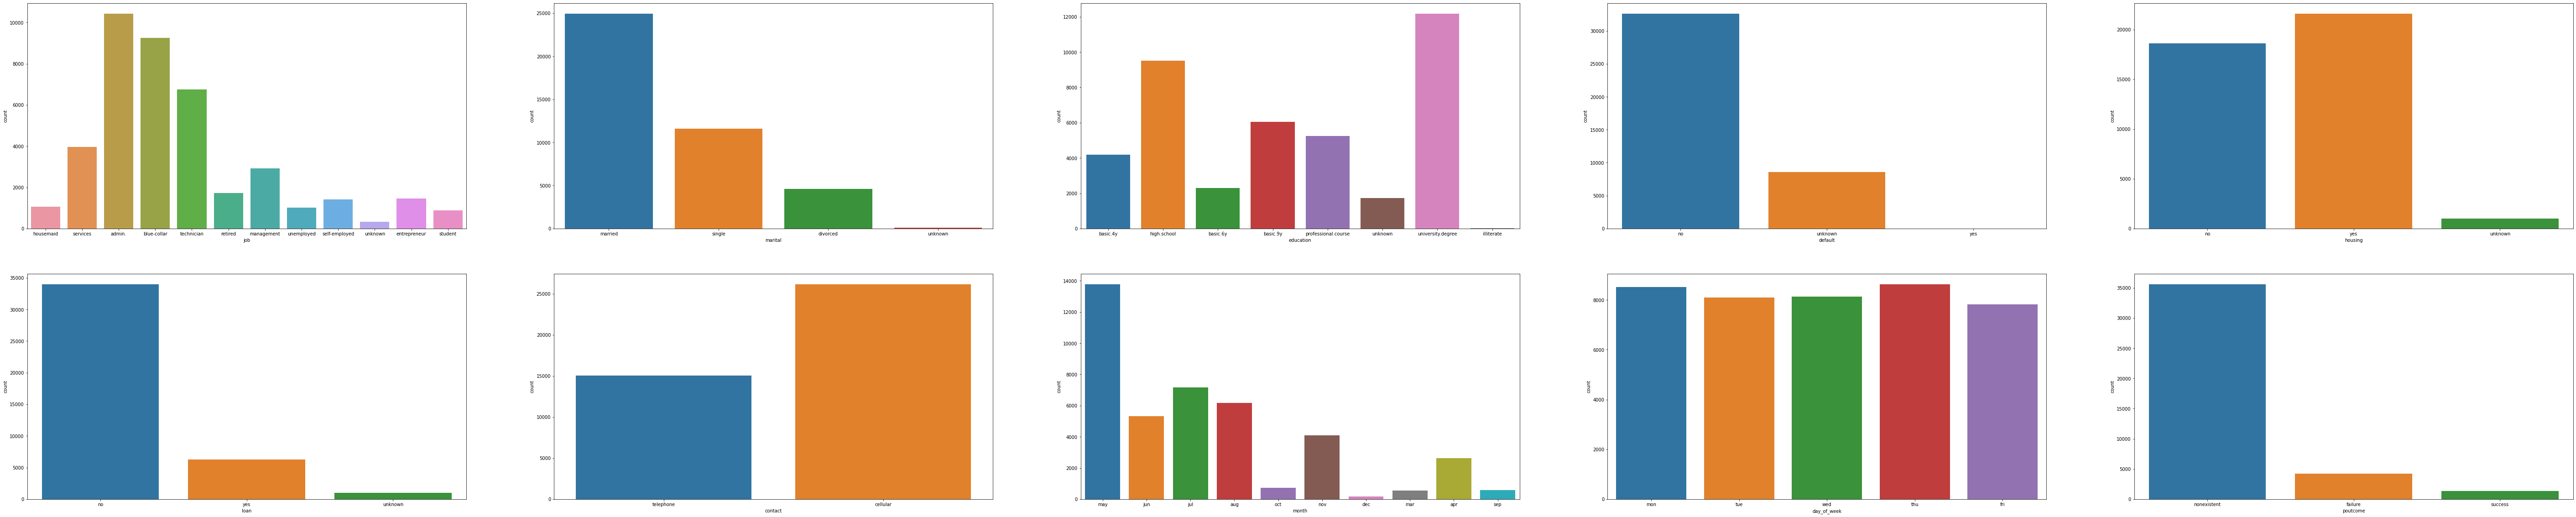

In [7]:
fig, axes = plt.subplots(2, 5, figsize = (100,20))

for i, j in zip(catData, axes.flatten()):
    sns.countplot(bank[i], ax = j)

><p style="font-family:'Courier New'">Visualisasi-visualisasi di atas hanya bertujuan untuk melihat secara kasar, kira-kira seberapa banyaknya data <i>unknown</i> dan <i>nonexistent</i> di suatu fitur. Dimana secara kasar, dapat dilihat banyaknya data <i>unknown</i> tidak terlalu signifikan. Namun menariknya data <i>nonexistent</i> sangat signifikan di fitur poutcome. Tapi nanti saya akan analisa lebih jauh lagi di bawah. 

## Categorical Feature

###### Mendeteksi data <i>unknown</i> 

<p style="font-family:'Courier New'">Sebetulnya dari visual di atas, kita dapat melihat di fitur-fitur mana yang terdapat data <i>unknown</i>, namun saya akan memastikannya lagi. 

In [8]:
ListU = []

for i in catData:
    if 'unknown' in bank[i].unique(): #jika ada data 'unknown' di unique sebuah fitur, kumpulkan fiturnya di listU
        ListU.append(i)
        
ListU   

['job', 'marital', 'education', 'default', 'housing', 'loan']

In [9]:
def UnknownTab(data):
    
    nUnknown = []
    
    for i in ListU:
        nUnknown.append(len(data[data[i] == 'unknown']))
    
    unknownTable = pd.DataFrame({'unknown' : nUnknown}, index = ListU)
    
    return unknownTable

UnknownTab(bank)

,unknown
job,330
marital,80
education,1731
default,8597
housing,990
loan,990


> <p style="font-family:'Courier New'">Tabel di atas adalah fitur-fitur yang mempunyai data <i>unknown</i> di dalamnya disertai dengan jumlah datanya. 

### education

In [10]:
bank['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

###### Correlation Analysis

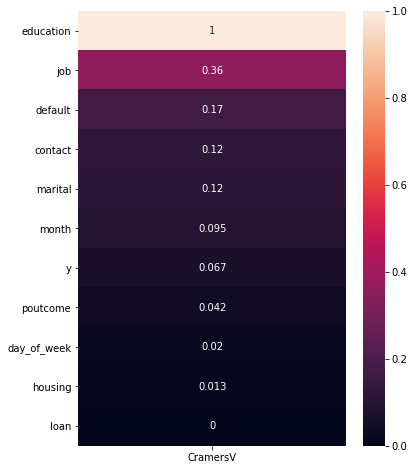

In [11]:
cramersEd = []

for i in catData:
    cramersEd.append(cramers_v(bank['education'],bank[i]))

plt.figure(figsize = (6,8))
sns.heatmap(pd.DataFrame({'CramersV' : cramersEd}, index = catData).sort_values(ascending = False, by = 'CramersV'), annot = True)

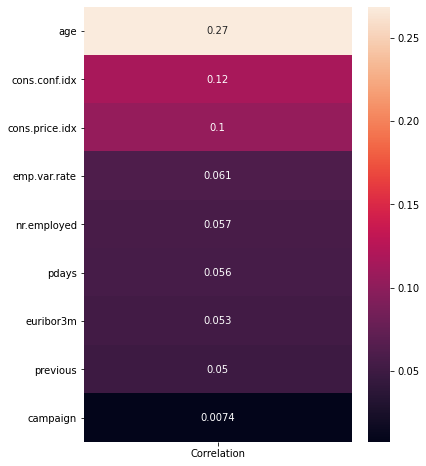

In [12]:
contData = bank.drop(catData, axis = 1)
corrEd = []
for i in contData.columns:
    corrEd.append(correlation_ratio(bank['education'],bank[i]))
    
plt.figure(figsize = (6,8))    
sns.heatmap(pd.DataFrame({'Correlation' : corrEd}, index = contData.columns).sort_values(ascending = False, by = 'Correlation'), annot = True) 

> <p style="font-family:'Courier New'">Dari analisa korelasi di atas, ditunjukkannya fitur <i>job</i> adalah fitur yang paling berkorelasi dengan fitur <i>education</i>, lalu disusul oleh fitur <i>age</i>.

In [13]:
pd.crosstab(bank['job'],bank['education'])

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,77,151,499,3329,1,363,5753,249
blue-collar,2318,1426,3623,878,8,453,94,454
entrepreneur,137,71,210,234,2,135,610,57
housemaid,474,77,94,174,1,59,139,42
management,100,85,166,298,0,89,2063,123
retired,597,75,145,276,3,241,285,98
self-employed,93,25,220,118,3,168,765,29
services,132,226,388,2682,0,218,173,150
student,26,13,99,357,0,43,170,167


In [14]:
bank[bank['education'] == 'unknown']['job'].unique()

array(['blue-collar', 'technician', 'admin.', 'unknown', 'management',
       'services', 'entrepreneur', 'retired', 'student', 'self-employed',
       'housemaid', 'unemployed'], dtype=object)

> <p style="font-family:'Courier New'">Terlihat hampir semua jenis pekerjaan memiliki data kosong di fitur education.

In [15]:
for i in bank[bank['education'] == 'unknown']['job'].unique():
    print(i)
    print(pd.crosstab(bank['job'],bank['education']).loc[i].sort_values(ascending = False).head(1).index)
    print('\n')

blue-collar
Index(['basic.9y'], dtype='object', name='education')


technician
Index(['professional.course'], dtype='object', name='education')


admin.
Index(['university.degree'], dtype='object', name='education')


unknown
Index(['unknown'], dtype='object', name='education')


management
Index(['university.degree'], dtype='object', name='education')


services
Index(['high.school'], dtype='object', name='education')


entrepreneur
Index(['university.degree'], dtype='object', name='education')


retired
Index(['basic.4y'], dtype='object', name='education')


student
Index(['high.school'], dtype='object', name='education')


self-employed
Index(['university.degree'], dtype='object', name='education')


housemaid
Index(['basic.4y'], dtype='object', name='education')


unemployed
Index(['university.degree'], dtype='object', name='education')




> Crosstab di atas, menunjukkan bahwa:
* Untuk pekerjaan <i> blue-collar </i> paling banyak ditingkat pendidikan <i> basic.9y </i>
* Untuk pekerjaan <i> technician </i> paling banyak ditingkat pendidikan <i> professional.course </i>
* Untuk pekerjaan <i> admin., entrepreneur, management, self-employed, unemployed </i> paling banyak ditingkat pendidikan <i> university.degree </i>
* Untuk pekerjaan <i> services, student </i> paling banyak ditingkat pendidikan <i> high.school </i>
* Untuk pekerjaan <i> retired, housemaid </i> paling banyak ditingkat pendidikan <i> basic.4y </i>

    
<p style="font-family:'Courier New'">Dengan begitu, saya dapat mengisi pendidikan yang bernilai <i>unknown</i> sesuai dengan pekerjaan yang paling sering muncul. 

In [16]:
def imputeUnknownEd(x): #x --> bank[['education'.'job']]
    if x['job'] == 'blue-collar' and x['education'] == 'unknown':
        return 'basic.9y'
    elif x['job'] == 'technician' and x['education'] == 'unknown':
        return 'professional.course'
    elif (x['job'] == 'admin.' or x['job'] == 'entrepreneur' or x['job'] == 'management' 
         or x['job'] == 'self-employed' or x['job'] == 'unemployed') and x['education'] == 'unknown':
        return 'university.degree'
    elif (x['job'] == 'services' or x['job'] == 'student') and x['education'] == 'unknown':
        return 'high.school'
    elif (x['job'] == 'retired' or x['job'] == 'housemaid') and x['education'] == 'unknown':
        return 'basic.4y'
    else:
        return x['education']

    
bank['education'] = bank[['education','job']].apply(imputeUnknownEd, axis = 1)

In [17]:
UnknownTab(bank)

,unknown
job,330
marital,80
education,131
default,8597
housing,990
loan,990


> <p style="font-family:'Courier New'">Namun, fitur <i> education </i> masih memiliki 131 data yang tidak diketahui. Yang artinya, ada data irisan yang <i>unknown</i> antara fitur <i> education </i> dan <i> job </i>

### job

In [18]:
bank['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

###### Correlation Analysis

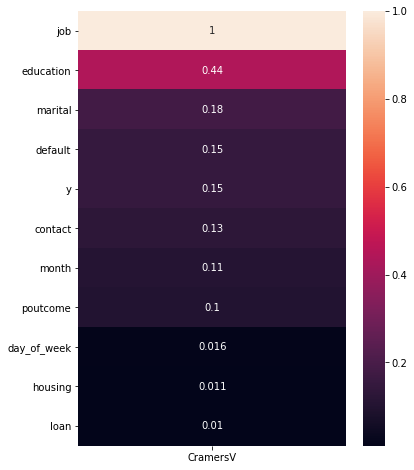

In [19]:
cramersJob = []

for i in catData:
    cramersJob.append(cramers_v(bank['job'],bank[i]))

plt.figure(figsize = (6,8))
sns.heatmap(pd.DataFrame({'CramersV' : cramersJob}, index = catData).sort_values(ascending = False, by = 'CramersV'), annot = True)

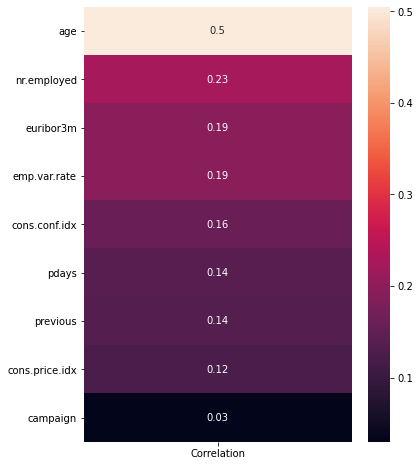

In [20]:
contData = bank.drop(catData, axis = 1)
corrJob = []
for i in contData.columns:
    corrJob.append(correlation_ratio(bank['job'],bank[i]))
    
plt.figure(figsize = (6,8))    
sns.heatmap(pd.DataFrame({'Correlation' : corrJob}, index = contData.columns).sort_values(ascending = False, by = 'Correlation'), annot = True)

> <p style="font-family:'Courier New'">Dari hasil korelasi di atas, untuk fitur <i> age </i> dan <i> job </i> memiliki korelasi yang tinggi. Kemudian seperti hasil sebelumnya, fitur <i> education </i> dan <i> job </i> memiliki korelasi yang juga tinggi. 

In [21]:
bank[bank['job'] == 'unknown']['education'].unique()

array(['university.degree', 'basic.4y', 'unknown', 'high.school',
       'basic.9y', 'basic.6y', 'professional.course'], dtype=object)

In [22]:
pd.crosstab(bank['education'],bank['job'])

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
education,,,,,,,,,,,,
basic.4y,77,2318,137,516,100,695,93,132,26,58,112,52
basic.6y,151,1426,71,77,85,75,25,226,13,87,34,22
basic.9y,499,4077,210,94,166,145,220,388,99,384,186,31
high.school,3329,878,234,174,298,276,118,2832,524,873,259,37
illiterate,1,8,2,1,0,3,3,0,0,0,0,0
professional.course,363,453,135,59,89,241,168,218,43,3532,142,12
university.degree,6002,94,667,139,2186,285,794,173,170,1809,281,45
unknown,0,0,0,0,0,0,0,0,0,0,0,131


> <p style="font-family:'Courier New'">Dapat dilihat dari crosstab di atas, bahwa alasan fitur <i>education</i> masih ada data <i>unknown</i>, dikarenakan adanya fitur <i>education</i> dan <i>job</i> yang sama-sama memiliki data <i>unknown</i>. Maka dengan begitu, dibutuhkannya fitur lain, yang juga memiliki korelasi terhadap fitur <i>job</i> yaitu pada fitur <i> age </i>.

In [23]:
for i in bank[bank['job'] == 'unknown']['education'].unique():
    print(i)
    print(pd.crosstab(bank['education'],bank['job']).loc[i].sort_values(ascending = False).head(1).index)
    print('\n')

university.degree
Index(['admin.'], dtype='object', name='job')


basic.4y
Index(['blue-collar'], dtype='object', name='job')


unknown
Index(['unknown'], dtype='object', name='job')


high.school
Index(['admin.'], dtype='object', name='job')


basic.9y
Index(['blue-collar'], dtype='object', name='job')


basic.6y
Index(['blue-collar'], dtype='object', name='job')


professional.course
Index(['technician'], dtype='object', name='job')




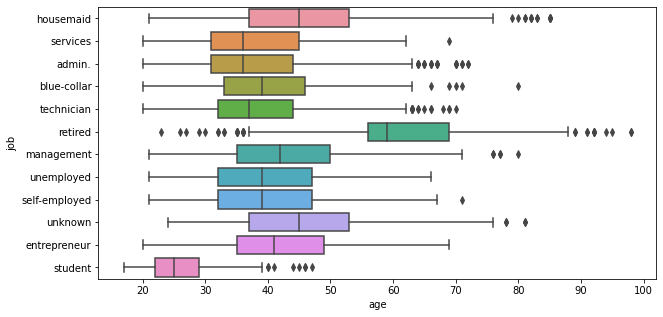

In [24]:
plt.figure(figsize = (10,5))
sns.boxplot(y = bank['job'], x = bank['age'])

> <p style="font-family:'Courier New'">Dari boxplot di atas, terlihat bahwa orang-orang yang memiliki pekerjaan <i>student</i> adalah anak-anak muda, tidak ada yang berumur 50 tahun atau lebih. Kemudian pekerjaan <i>retired</i> pekerjaan yang hampir di isi dengan kalangan umur namun 50% data berada di sekitar 50an tahun dan 70an tahun. Sisanya tidak terlalu menunjukkan perbedaan yang signifikan. 

In [25]:
for i in ['student','retired']:
    print('median {}'.format(i))
    print(bank[bank['job']==i]['age'].describe()['50%'])
    print('==================================')

median student
25.0
median retired
59.0


In [26]:
bank[(bank['age'] >= 25) & (bank['age'] <= 59)]['job'].value_counts().head(1)

admin.    10159
Name: job, dtype: int64

In [27]:
def imputeUnknownJob(x): # x --> bank[['education','job','age']]
    if x['education'] == 'university.degree' and x['job'] == 'unknown':
        return 'admin.'
    elif x['education'] == 'basic.4y' and x['job'] == 'unknown':
        return 'blue-collar'
    elif x['education'] == 'high.school' and x['job'] == 'unknown':
        return 'admin.'
    elif x['education'] == 'basic.9y' and x['job'] == 'unknown':
        return 'blue-collar'
    elif x['education'] == 'basic.6y' and x['job'] == 'unknown':
        return 'blue-collar'
    elif x['education'] == 'professional.course' and x['job'] == 'unknown':
        return 'technician'
    elif x['age'] > 59 and x['job'] == 'unknown':
        return 'retired'
    elif x['age'] < 25 and x['job'] == 'unknown':
        return 'student'
    elif x['age'] >= 25 and x['age'] <= 59 and x['job'] == 'unknown':
        return 'admin.'
    else:
        return x['job']

In [28]:
bank['job'] = bank[['education','job','age']].apply(imputeUnknownJob , axis = 1)

> <p style="font-family:'Courier New'">Di keadaan ini, seharusnya data di fitur <i>job</i> sudah tidak memiliki data <i>unknown</i>, jadi kita panggil lagi fungsi <i>education</i> di atas, dan mengisinya lagi. 

In [29]:
bank['education'] = bank[['education','job']].apply(imputeUnknownEd, axis = 1)
bank['job'] = bank[['education','job','age']].apply(imputeUnknownJob , axis = 1)

> <p style="font-family:'Courier New'">Mari kita cek kembali table <i>unknown</i>.  

In [30]:
UnknownTab(bank)

,unknown
job,0
marital,80
education,0
default,8597
housing,990
loan,990


> <p style="font-family:'Courier New'">Fitur <i> job </i> dan <i> education </i> tidak lagi memiliki data <i> unknown </i></p> 

### marital

In [31]:
bank['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

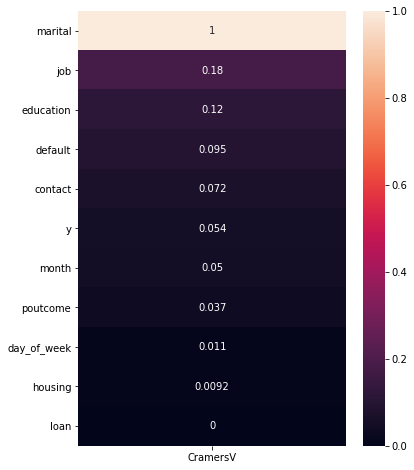

In [32]:
cramersMar = []

for i in catData:
    cramersMar.append(cramers_v(bank['marital'],bank[i]))

plt.figure(figsize = (6,8))
sns.heatmap(pd.DataFrame({'CramersV' : cramersMar}, index = catData).sort_values(ascending = False, by = 'CramersV'), annot = True)

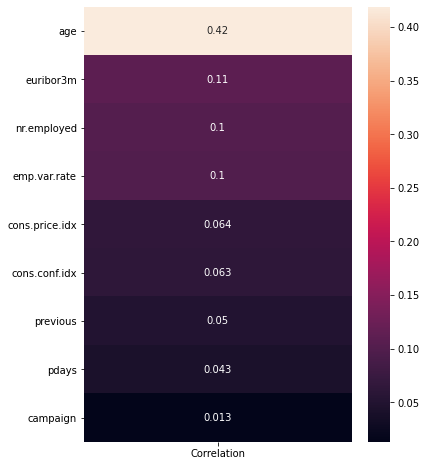

In [33]:
contData = bank.drop(catData, axis = 1)
corrMar = []
for i in contData.columns:
    corrMar.append(correlation_ratio(bank['marital'],bank[i]))

plt.figure(figsize = (6,8))
sns.heatmap(pd.DataFrame({'Correlation' : corrMar}, index = contData.columns).sort_values(ascending = False, by = 'Correlation'), annot = True) 

> <p style="font-family:'Courier New'">Dari analisa korelasi di atas, dapat dilihat bahwa fitur <i>age</i> memiliki korelasi tertinggi.

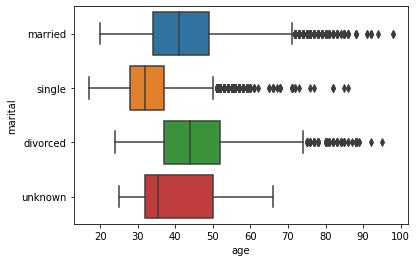

In [34]:
sns.boxplot(y = bank['marital'], x = bank['age'])

> <p style="font-family:'Courier New'">Orang-orang yang single memiliki umur yang tidak sevariasi dari status-status lainnya, kebanyakan mereka berumuran di antara 20an tahun sampai 40an tahun. Sedangkan orang-orang yang berstatus divorced dan married tidak terlalu punya perbedaan yang signifikan. 

###### Mencoba untuk mencari range umur untuk marital

In [158]:
bank[bank['marital'] == 'married']['age'].describe()

count    24984.000000
mean        42.312680
std         10.018258
min         20.000000
25%         34.000000
50%         41.000000
75%         49.000000
max         98.000000
Name: age, dtype: float64

In [160]:
bank[bank['marital'] == 'divorced']['age'].describe()

count    4612.000000
mean       44.899393
std        10.625599
min        24.000000
25%        37.000000
50%        44.000000
75%        52.000000
max        95.000000
Name: age, dtype: float64

In [159]:
bank[bank['marital'] == 'single']['age'].describe()

count    11592.000000
mean        33.151743
std          7.528865
min         17.000000
25%         28.000000
50%         32.000000
75%         37.000000
max         86.000000
Name: age, dtype: float64

In [35]:
bank['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [36]:
bank.groupby('marital').median()['age']

marital
divorced    44.0
married     41.0
single      32.0
unknown     35.5
Name: age, dtype: float64

In [37]:
bank[bank['age']<=32]['marital'].value_counts()

single      6418
married     4235
divorced     499
unknown       24
Name: marital, dtype: int64

In [38]:
bank[(bank['age']>32) & (bank['age']<=41)]['marital'].value_counts()

married     8724
single      3692
divorced    1428
unknown       26
Name: marital, dtype: int64

In [39]:
bank[(bank['age']>41) & (bank['age']<=66)]['marital'].value_counts()

married     11580
divorced     2532
single       1438
unknown        30
Name: marital, dtype: int64

> <p style="font-family:'Courier New'">Sangat sulit melihat pola untuk marital = <i>divorced</i>. Jadi saya putuskan untuk mengisinya hanya dengan <i>married</i> dan <i>single</i>, dikarenakan status <i>married</i> dan <i>single</i> cukup dominan. 

In [42]:
def imputeUnknownMarital(x): # x --> bank[['age','marital']]
    if x['age'] <= 32 and x['marital'] == 'unknown':
        return 'single'
    elif x['age'] > 32 and x['marital'] == 'unknown':
        return 'married'
    else:
        return x['marital']        

In [43]:
bank['marital'] = bank[['age','marital']].apply(imputeUnknownMarital, axis = 1)

In [44]:
UnknownTab(bank)

,unknown
job,0
marital,0
education,0
default,8597
housing,990
loan,990


### housing and loan

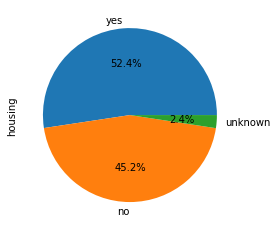

In [45]:
bank['housing'].value_counts().plot(kind = 'pie',autopct='%1.1f%%')

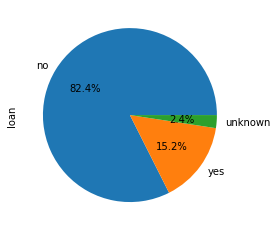

In [46]:
bank['loan'].value_counts().plot(kind = 'pie',autopct='%1.1f%%')

In [47]:
cramers_v(bank['housing'], bank['loan'])

0.7078524775105789

> <p style="font-family:'Courier New'">Dua fitur ini punya korelasi yang kuat (maka seharusnya tidak masalah jika nanti saya drop salah satunya) dan crosstab mereka yang menunjukkan bahwa sepertinya mereka tidak ditanyakan informasi tentang pinjaman mereka. 

In [48]:
pd.crosstab(bank['housing'],bank['loan'])

loan,no,unknown,yes
housing,,,
no,16065,0,2557
unknown,0,990,0
yes,17885,0,3691


In [49]:
cramersHouse = []

for i in catData:
    cramersHouse.append(cramers_v(bank['housing'],bank[i]))

pd.DataFrame({'CramersV' : cramersHouse}, index = catData).loc[['y']]

,CramersV
y,0.009458


In [50]:
cramersLoan = []

for i in catData:
    cramersLoan.append(cramers_v(bank['loan'],bank[i]))

pd.DataFrame({'CramersV' : cramersLoan}, index = catData).loc[['y']]

,CramersV
y,0.0


> <p style="font-family:'Courier New'">Dapat dilihat korelasi target dengan kedua fitur tersebut tidaklah kuat cenderung tidak ada korelasi. 

In [51]:
chi2_ = []

for i in ['loan','housing']:
    if chi2_contingency(pd.crosstab(bank['y'],bank[i]))[1] < 0.05:
        chi2_.append('Reject Null Hypothesis')
    else:
        chi2_.append('Fail to Reject Null Hypothesis')

pd.DataFrame({'hypothesis' : chi2_}, index = ['loan','housing'])

,hypothesis
loan,Fail to Reject Null Hypothesis
housing,Fail to Reject Null Hypothesis


> <p style="font-family:'Courier New'">Sebetulnya ini cukup <i>counter-intuitive</i> mengingat secara intuisi seharusnya ada pengaruh fitur <i>loan</i> dan <i>housing</i> dengan target. Dimana suku bunga pinjaman seharusnya punya pengaruh pada suku bunga deposito. Namun statistik memperlihatkan hal yang berbeda, pada dataset ini 
fitur <i>loan</i> dan <i>housing</i> tidaklah signifikan, jadi saya putuskan untuk membuangnya. 

In [52]:
bank.drop(['loan','housing'], inplace = True, axis = 1)

### default

In [53]:
bank['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

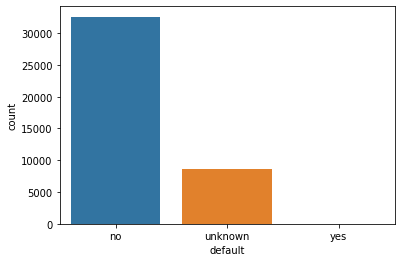

In [54]:
sns.countplot(bank['default'])

> <p style="font-family:'Courier New'">Nilai <i>unknown</i> dalam fitur <i>default</i> tidak perlu dibuang atau diisi, dikarenakan adanya kemungkinan nasabah menolak untuk memberitahunya ke pihak bank. 

## Numerical Feature

### pdays

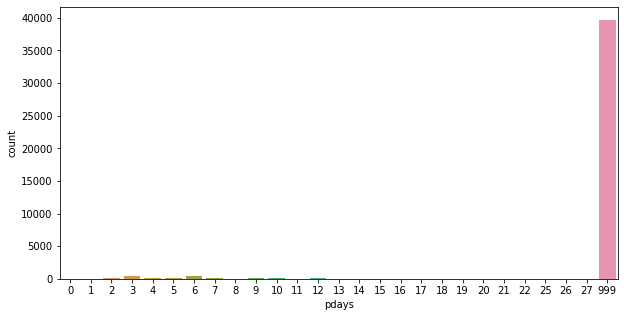

In [55]:
plt.figure(figsize = (10,5))
sns.countplot(bank['pdays'])

    pdays: number of days that passed by after the client was last contacted from a 
    previous campaign 
    (numeric; 999 means client was not previously contacted)

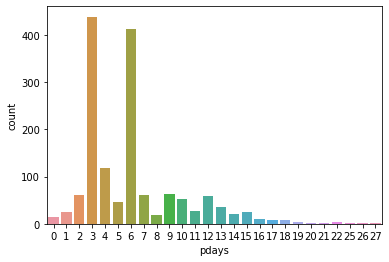

In [56]:
sns.countplot(bank[bank['pdays'] != 999]['pdays'])

> <p style="font-family:'Courier New'">Dari dataset di atas dikatakan pdays = '999' adalah tanda untuk nasabah yang belum dikontak sebelumnya, jadi sebaiknya saya lihat fitur <i>poutcome</i>. 

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64


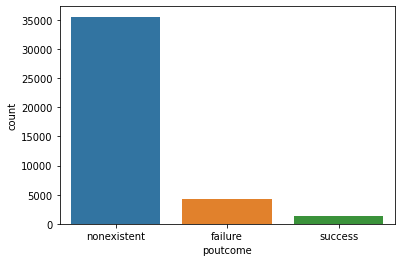

In [57]:
print(bank['poutcome'].value_counts())
sns.countplot(bank['poutcome'])
plt.show()

> <p style="font-family:'Courier New'">Adanya hasil yang bernilai (<i>nonexistent</i>) kemungkinan dikarenakan mereka adalah nasabah-nasabah baru di bank ini. Jadi artinya dataset ini di dominasi oleh nasabah-nasabah baru.  

In [58]:
pd.crosstab(bank['pdays'], bank['poutcome'])

poutcome,failure,nonexistent,success
pdays,,,
0,0,0,15
1,0,0,26
2,0,0,61
3,4,0,435
4,2,0,116
5,4,0,42
6,25,0,387
7,15,0,45
8,6,0,12


> <p style="font-family:'Courier New'">Dari crosstab di atas, dapat disimpulkan bahwa nasabah-nasabah yang memiliki pdays = '999' adalah nasabah-nasabah yang belum pernah dikontak sebelumnya. Antara lain mungkin nasabah itu pernah ditelpon sebelumnya namun gagal (<i>failure</i>) atau tidak ada hasil (<i>nonexistent</i>) dikarenakan mereka adalah nasabah-nasabah baru yang belum sempat dihubungi. Dan pdays = '999' sangat dominan difitur ini. 

> <p style="font-family:'Courier New'">Untuk fitur ini, saya akan melakukan <i>bining</i>. Dimana untuk pdays = '999' menjadi <i>Never contacted before</i>. Sedangkan untuk sisanya, saya menggantinya menjadi <i>Contacted</i> yang dimana untuk nasabah-nasabah yang pernah dikontak sebelumnya. 

In [59]:
def binPdays(x):
    if x == 999:
        return 'Never contacted before'
    else:
        return 'Contacted'

In [60]:
bank['pdays'] = bank['pdays'].apply(binPdays)

# Handling Outliers

In [61]:
numData = bank.drop(bank.select_dtypes(exclude = np.number).columns, axis = 1)
numData.columns

Index(['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], dtype='object')

In [62]:
out = []
Q1 = {}
Q3 = {}
IQR = {}
len_data_outlier = {}

for i in numData.columns:
    Q1[i] = bank[i].describe()['25%']
    Q3[i] = bank[i].describe()['75%']
    IQR[i] = Q3[i] - Q1[i]
    len_data_outlier[i] = len(bank[(bank[i] < Q1[i] - (1.5*IQR[i])) | (bank[i] > Q3[i] + (1.5 * IQR[i]))])
    
for i,j in len_data_outlier.items():
    if j == 0:
        print('Tidak terdapat outliers di fitur {}'.format(i))
    else:
        print('Terdapat outliers di fitur {}'.format(i))
        out.append(i)

Terdapat outliers di fitur age
Terdapat outliers di fitur campaign
Terdapat outliers di fitur previous
Tidak terdapat outliers di fitur emp.var.rate
Tidak terdapat outliers di fitur cons.price.idx
Terdapat outliers di fitur cons.conf.idx
Tidak terdapat outliers di fitur euribor3m
Tidak terdapat outliers di fitur nr.employed


In [63]:
def outliers_detect(x):
    Q1 = bank[x].describe()['25%']
    Q3 = bank[x].describe()['75%']
    IQR = Q3-Q1
    return bank[(bank[x] < Q1 - (1.5*IQR)) | (bank[x] > Q3 + (1.5 * IQR))][x]  

In [64]:
from scipy.stats import kurtosis,skew

nOutlier = []
percOutlier = []
Kurtosis = []

for i in out:
    nOutlier.append(len(outliers_detect(i)))
    percOutlier.append( (len(outliers_detect(i))/len(bank)) * 100 )
    Kurtosis.append(kurtosis(bank[i]))
    
pd.DataFrame({'nOutliers' : nOutlier, 'percOutliers' : percOutlier, 'kurtosis' : Kurtosis}, index = out).sort_values(by = 'kurtosis', ascending = False)  

,nOutliers,percOutliers,kurtosis
campaign,2406,5.841507,36.97516
previous,5625,13.656890,20.10623
age,469,1.138681,0.79107
cons.conf.idx,447,1.085268,-0.35866


In [65]:
bank.describe()[['previous','campaign','age','cons.conf.idx']].loc[['min','max', 'mean','std']]

,previous,campaign,age,cons.conf.idx
min,0.000000,1.000000,17.00000,-50.800000
max,7.000000,56.000000,98.00000,-26.900000
mean,0.172963,2.567593,40.02406,-40.502600
std,0.494901,2.770014,10.42125,4.628198


> <p style="font-family:'Courier New'">Dalam menangani <i>outliers</i>, biasanya saya lebih menfokuskan pada nilai kurtosis daripada jumlah outliers, dikarenakan kurtosis sangat dipengaruhi dengan adanya data <i> rare extreme observation </i> dari sebuah fitur. Dan dari data di atas, ditunjukkan bahwa fitur <i>campaign</i> dan <i>previous</i> memiliki kurtosis yang tinggi.

Referensi: https://en.wikipedia.org/wiki/Talk:Kurtosis#Why_kurtosis_should_not_be_interpreted_as_%22peakedness%22

## previous

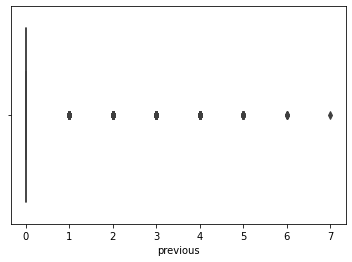

In [66]:
sns.boxplot(bank['previous'])

In [67]:
categoryData = bank.drop(numData.columns, axis = 1)
corrPrev = []

for i in categoryData.columns:
    corrPrev.append(correlation_ratio(bank[i],bank['previous']))

pd.DataFrame({'CramersV' : corrPrev}, index = categoryData.columns).sort_values(ascending = False, by = 'CramersV') 

,CramersV
poutcome,0.888135
pdays,0.587462
month,0.280649
y,0.230181
contact,0.212848
job,0.136336
default,0.102630
marital,0.049859
education,0.047651
day_of_week,0.005755


> <p style="font-family:'Courier New'">Fitur <i>previous</i> memiliki korelasi sangat kuat dengan fitur <i>pdays</i> dan <i>poutcome</i>, jadi seharusnya tidaklah masalah jika saya membuang fitur ini. 

In [68]:
bank.drop('previous', inplace = True, axis = 1)

## campaign

<p style="font-family:'Courier New'">Fitur campaign berisikan berapa banyak pengontakan dilakukan ke nasabah untuk kampanye kali ini. 

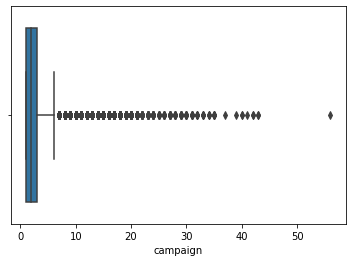

In [69]:
sns.boxplot(bank['campaign'])

> <p style="font-family:'Courier New'">Adanya nasabah yang perlu dikontak lebih dari 50 kali. Mungkin adanya alasan khusus atau sesuatu keperluan khusus. Saya tidak dapat memastikan apakah itu outliers atau tidak. Mengingat adanya juga nasabah-nasabah yang dikontak lebih dari 40 kali. Jadi sebaiknya, saya biarkan begitu. 

# Drop unimportant Feature

## Contact

In [70]:
bank['contact'].unique()

array(['telephone', 'cellular'], dtype=object)

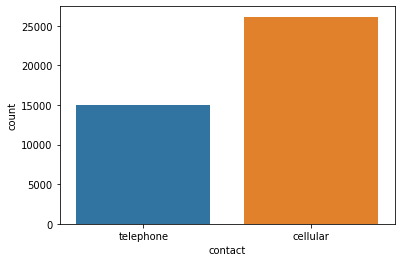

In [71]:
sns.countplot(bank['contact'])

> <p style="font-family:'Courier New'">Saya akan membuang fitur <i>contact</i>, karena menurut saya, tidak ada pengaruh nasabah ditelfon melalui ponsel atau tidak.

In [72]:
bank = bank.drop('contact', axis = 1)

## day_of_week

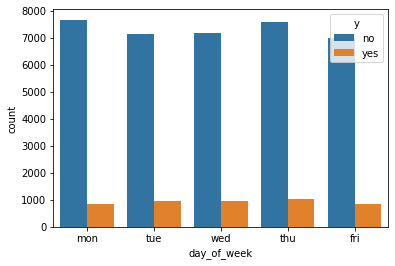

In [73]:
sns.countplot(bank['day_of_week'], hue = bank['y'])

> <p style="font-family:'Courier New'">Dapat dilihat dari visualisasi data di atas, dimana di setiap hari kerja punya distribusi yang 
hampir sama rata atau tidak punya perbedaan yang signifikan. Jadi boleh dibilang, fitur <i>day_of_week</i> tidak terlalu berguna untuk memprediksi nasabah akan melakukan deposito atau tidak. 

In [74]:
bank = bank.drop('day_of_week', axis = 1)

# Exploratory analysis

In [75]:
bank_clean = bank.copy()

In [76]:
bank_clean.to_csv('bank_clean.csv', index = False)

In [77]:
bank_clean.head()

,age,job,marital,education,default,month,campaign,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [78]:
bank_clean.describe()

,age,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


<b>Numerical Features</b>

> * <p style="font-family:'Courier New'">Dari data deskripsi di atas, nasabah termuda berumur 17 tahun dan tertua berumur 98 tahun.
* <p style="font-family:'Courier New'">Pengontakan terbanyak terjadi 56 kali dan terdikit terjadi 1 kali. 
* <p style="font-family:'Courier New'">cons.price.idx memiliki distribusi paling lancip diantara fitur-fitur lainnya. 


In [79]:
bank_clean.describe(exclude = np.number)

,job,marital,education,default,month,pdays,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188
unique,11,3,7,3,10,2,3,2
top,admin.,married,university.degree,no,may,Never contacted before,nonexistent,no
freq,10618,24984,12759,32588,13769,39673,35563,36548


<b> Categorical Features </b>

>* <p style="font-family:'Courier New'">Adanya 11 macam pekerjaan di dataset ini, dan didominasi dengan orang-orang yang bekerja sebagai admin. yang banyaknya 10618 orang.
* <p style="font-family:'Courier New'">Bulan Mei adalah bulan terbanyak terjadinya pengontakan.
* <p style="font-family:'Courier New'">39673 orang-orang belum pernah dihubungi sebelumnya yang seperti analisa sebelumnya, dimana orang-orang itu gagal dihubungi (<i>failure</i>) atau tidak ada (<i>nonexistent</i>).
* <p style="font-family:'Courier New'">Mayoritas orang tidak melakukan deposito.

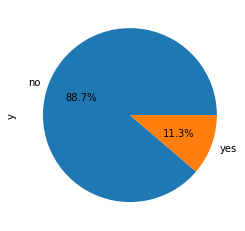

In [80]:
bank['y'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')

> <p style="font-family:'Courier New'">Dataset ini dapat dikategorikan dataset yang <i>highly-unbalanced.</i> Jadi artinya akurasi tidak menjadi relevan saat melakukan evaluasi.

In [81]:
catBank_clean = bank_clean.select_dtypes(exclude = np.number)
numBank_clean = bank.drop(catBank_clean.columns, axis = 1)

## Correlation Analysis

### Numerical

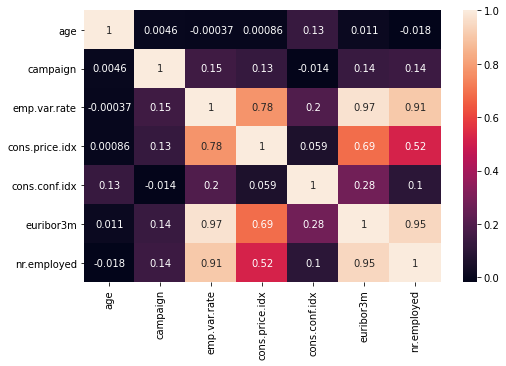

In [82]:
plt.figure(figsize = (8,5))
sns.heatmap(numBank_clean.corr(), annot = True)

> <p style="font-family:'Courier New'">Dari matriks korelasi di atas, menunjukkan untuk fitur sosial dan ekonomi (<i> euribor3m, nr.employed, cons.conf.idx, cons.price.idx </i>) mereka saling berkorelasi satu sama lain, terutama <i> euribor3m </i> dan <i> emp.var.rate </i>. Untuk fitur sosial dan ekonomi akan saya analisa di <i>section 3.4</i>. 

### Categorical

In [83]:
corrCat = []

for i in catBank_clean.columns:
    mat = []
    for j in catBank_clean.columns:
        mat.append(cramers_v(bank_clean[i],bank_clean[j]))
    corrCat.append(mat)

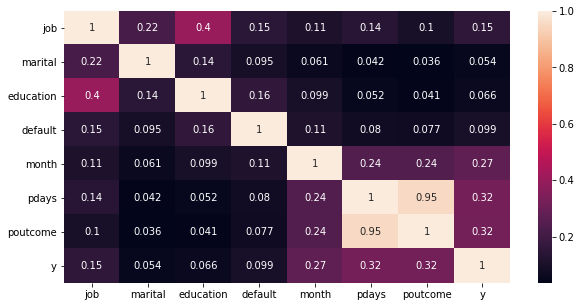

In [84]:
dfcramers = pd.DataFrame(corrCat, index = catBank_clean.columns, columns = catBank_clean.columns)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

> <p style="font-family:'Courier New'">Dari matriks korelasi di atas, menunjukkan untuk fitur <i>month</i>, <i>pdays</i> dan <i>poutcome</i> punya korelasi pada target. Ini jadi <i>insight</i> yang menarik, artinya pemilihan bulan dalam melakukan penawaran deposito juga punya hubungan nasabah akan melakukan deposito atau tidak. Sedangkan untuk fitur <i>pdays</i> dan <i>poutcome</i> harus kita analisa lagi di bawah. 

### Numerical and Categorical

In [85]:
corrNumCat = []

for i in catBank_clean.columns:
    mat2 = []
    for j in numBank_clean.columns:
        mat2.append(correlation_ratio(bank_clean[i],bank_clean[j]))
    corrNumCat.append(mat2)

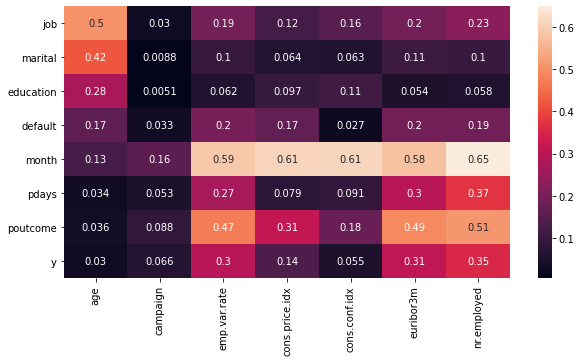

In [86]:
dfcramers = pd.DataFrame(corrNumCat, index = catBank_clean.columns, columns = numBank_clean.columns)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

> <p style="font-family:'Courier New'">Dari matriks korelasi di atas, menunjukkan untuk fitur <i>eruribor3m</i> dan <i>nr.employed</i> punya korelasi yang kuat pada target. Mengingat matriks korelasi sebelum-sebelumnya yang memperlihatkan adanya korelasi yang kuat antar fitur socio-economic. Maka boleh dibilang, fitur-fitur socio-economic juga menjadi fitur penting pada prediksi target. 

## Hypothesis Testing


### Normality Tests

$H_{0}$: data are normally distributed. <br>

In [87]:
shap = []

for i in numBank_clean.columns:
    if shapiro(bank_clean[i])[1] < 0.05:
        shap.append('Reject Null Hypothesis')
    else:
        shap.append('Fail To reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : shap}, index = numBank_clean.columns)

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


### Significance Tests

$H_{0}$: the medians of the samples are equal. <br>

In [88]:
chi2 = []

for i in catBank_clean.columns:
    if chi2_contingency(pd.crosstab(bank_clean['y'], bank_clean[i]))[1] < 0.05:
        chi2.append('Reject Null Hypothesis')
    else:
        chi2.append('Fail To Reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : chi2}, index = catBank_clean.columns)

,Hypothesis
job,Reject Null Hypothesis
marital,Reject Null Hypothesis
education,Reject Null Hypothesis
default,Reject Null Hypothesis
month,Reject Null Hypothesis
pdays,Reject Null Hypothesis
poutcome,Reject Null Hypothesis
y,Reject Null Hypothesis


In [89]:
mannwhit = []

for i in numBank_clean.columns:
    if mannwhitneyu(bank[bank_clean['y'] == 'no'][i],bank[bank_clean['y'] == 'yes'][i])[1] < 0.05:
        mannwhit.append('Reject Null Hypothesis')
    else:
        mannwhit.append('Fail To reject Null Hypothesis')

pd.DataFrame({'Hypothesis' : mannwhit}, index = numBank_clean.columns)

,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


## Success Rate

### age

> <p style="font-family:'Courier New'">Dilakukannya Bining pada fitur <i> age </i>, dikarenakan saya ingin melihat bagaimana tingkat kesuksesan nasabah melakukan deposito berdasarkan kelompok-kelompok umur. Dan bagaimana saya mengelompokkan umur, terinspirasi dari paper: <i>Classification of Age Groups Based on Facial Features by: Wen-Bing Horng, Cheng-Ping Lee, and Chun-Wen Chen </i>

Sumber: https://www.researchgate.net/publication/228404297_Classification_of_Age_Groups_Based_on_Facial_Features

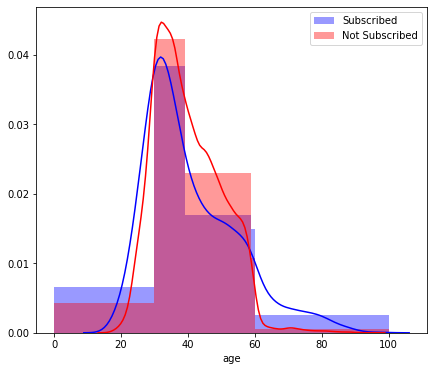

In [90]:
plt.figure(figsize = (7,6))

sns.distplot(bank_clean[bank_clean['y'] == 'yes']['age'], bins = [0, 30, 39, 59, 60, 100], color = 'b', label = 'Subscribed')
sns.distplot(bank_clean[bank_clean['y'] == 'no']['age'], bins = [0, 30, 39, 59, 60, 100], color = 'r', label = 'Not Subscribed')

plt.legend()

> <p style="font-family:'Courier New'">Dapat dilihat bahwa orang-orang yang berumur diatas 60 tahun dan dibawah 30 tahun cenderung melakukan deposito. Sedangkan untuk orang yang berumur 30 tahun dan 60 tahun cenderung orang tidak melakukan deposito. Namun mari kita lanjutkan analisanya. 

In [91]:
def classAge(x):
    if x < 30:
        return '<30'
    elif x>=30 and x< 40:
        return '30-39'
    elif x>40 and x< 60:
        return '40-59'
    else:
        return '60+'

In [92]:
ageGroup = bank['age'].apply(classAge)

30-39    16938
40-59    16227
<30       5669
60+       2354
Name: age, dtype: int64


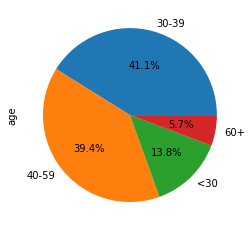

In [93]:
print(ageGroup.value_counts())
ageGroup.value_counts().plot(kind = 'pie',autopct='%1.1f%%')
plt.show()

In [94]:
dfClassAge = pd.concat([ageGroup, bank_clean['y']], axis = 1)

In [95]:
pd.crosstab(dfClassAge['y'],dfClassAge['age'])

age,30-39,40-59,60+,<30
y,,,,
no,15223,14780,1798,4747
yes,1715,1447,556,922


In [96]:
persenE = []

for i in dfClassAge['age'].unique():
    len_y = len(dfClassAge[(dfClassAge['y'] == 'yes') & (dfClassAge['age'] == i)])
    persenE.append((len_y/len(dfClassAge[dfClassAge['age'] == i]))*100)
    
persentE = pd.DataFrame(data = persenE, index = dfClassAge['age'].unique(), columns = ['Success Rate %']).sort_values(by = 'Success Rate %', ascending = False)
persentE['Total'] = dfClassAge['age'].value_counts()
persentE

,Success Rate %,Total
60+,23.619371,2354
<30,16.263891,5669
30-39,10.125162,16938
40-59,8.917237,16227


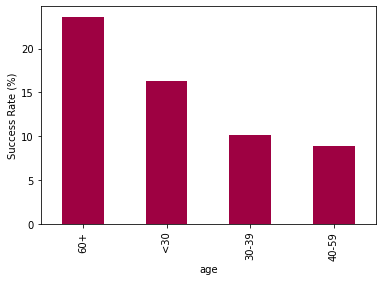

In [97]:
plt.ylabel('Success Rate (%)')
plt.xlabel('age')
persentE['Success Rate %'].plot(kind = 'bar', cmap = 'Spectral')

<p style="font-family:'Courier New'">Analisa di atas menunjukkan bahwa orang-orang yang berumur di atas 60 tahun dan di bawah 30 tahun memiliki <i> successs rate </i> yang tinggi. 

>* <p style="font-family:'Courier New'">Temuan ini sangatlah masuk akal, mengingat orang-orang yang berumur di atas 60 tahun, biasanya mereka menginginkan alat investasi yang punya resiko rendah, dan deposito adalah alat investasi yang sangat cocok buat mereka. 
<br>
* <p style="font-family:'Courier New'">Sedangkan untuk orang-orang yang berumur di bawah 30 tahun, biasanya mereka belum memiliki pengalaman atau pengetahuan tentang investasi, maka deposito adalah alat investasi yang aman buat mereka. 

> <p style="font-family:'Courier New'"><i> Rekomendasi: Target ke nasabah yang berumur di atas 60 tahun atau di bawah 30 tahun, daripada orang-orang yang berumur di antara 30 tahun dan 60 tahun. </i>

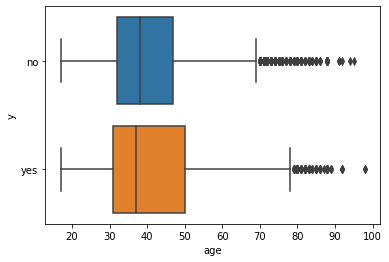

In [98]:
sns.boxplot(x = bank['age'], y = bank['y'])

> <p style="font-family:'Courier New'">Boxplot di atas terlihat orang-orang yang melakukan deposito umurnya lebih bervariasi daripada orang-orang yang tidak melakukan deposito. Namun secara median tidak terlalu punya perbedaan yang signifikan.  

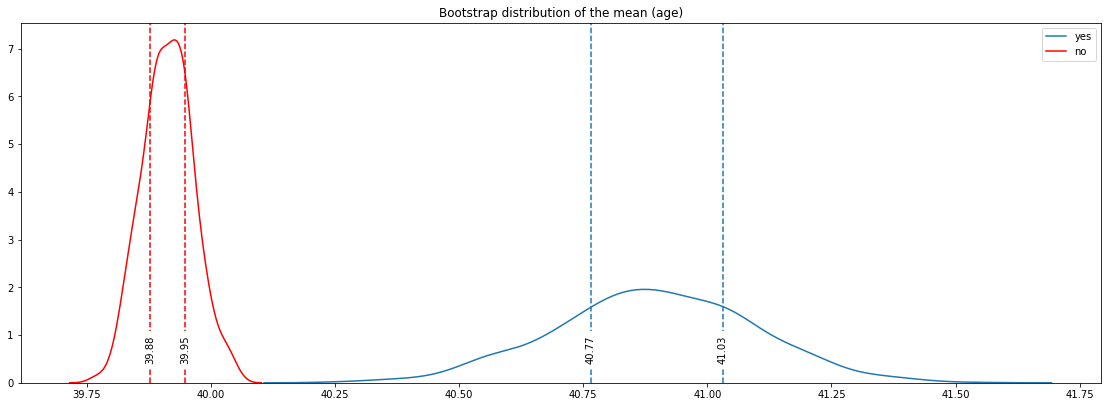

In [99]:
clt('age')

> <p style="font-family:'Courier New'"> Dari bootstrap distribution di atas, terlihat bahwa populasi orang-orang yang melakukan deposito rata-rata berumur lebih tua daripada yang tidak melakukan deposito. 

### job

In [100]:
pd.crosstab(bank_clean['y'],bank_clean['job'])

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
y,,,,,,,,,,,
no,9244,8715,1332,954,2596,1295,1272,3646,600,6024,870
yes,1374,644,124,106,328,442,149,323,275,731,144


In [101]:
persenJob = []

for i in bank_clean['job'].unique():
    len_y = len(bank_clean[(bank_clean['y'] == 'yes') & (bank_clean['job'] == i)])
    persenJob.append((len_y/len(bank_clean[bank_clean['job'] == i]))*100)
    
persentJob = pd.DataFrame(data = persenJob, index = bank_clean['job'].unique(), columns = ['Success Rate %']).sort_values(by = 'Success Rate %', ascending = False)
persentJob['Total'] = bank_clean['job'].value_counts()
persentJob

,Success Rate %,Total
student,31.428571,875
retired,25.446172,1737
unemployed,14.201183,1014
admin.,12.940290,10618
management,11.217510,2924
technician,10.821614,6755
self-employed,10.485574,1421
housemaid,10.000000,1060
entrepreneur,8.516484,1456
services,8.138070,3969


> <p style="font-family:'Courier New'">Temuan di atas, tidaklah mengagetkan. Mengingat bahwa dari fitur <i>age</i> kita sudah melihat <i> Success Rate </i> untuk orang yang berumur di atas 60 dan di bawah 30 punya success rate yang tinggi. Dengan kata lain, jika kita melihat dari segi pekerjaan, biasanya orang-orang yang berumur di bawah 30 adalah seorang <i> student </i> bisa di sekolah atau universitas. Sedangkan untuk orang yang berumur di atas 60 kemungkinan mereka sudah pensiun.

> <i> <p style="font-family:'Courier New'">Rekomendasi: <br> Utamakan nasabah yang punya pekerjaan sebagai mahasiswa atau pensiunan.

### education

In [102]:
pd.crosstab(bank_clean['y'],bank_clean['education'])

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree
y,,,,,,,
no,3859,2104,6002,8723,14,4835,11011
yes,474,188,497,1109,4,620,1748


In [103]:
perseneducation = []

for i in bank_clean['education'].unique():
    len_y = len(bank_clean[(bank_clean['y'] == 'yes') & (bank_clean['education'] == i)])
    perseneducation.append((len_y/len(bank_clean[bank_clean['education'] == i]))*100)
    
persenteducation = pd.DataFrame(data = perseneducation, index = bank_clean['education'].unique(), columns = ['Success Rate %']).sort_values(by = 'Success Rate %', ascending = False)
persenteducation['Total'] = bank_clean['education'].value_counts()
persenteducation

,Success Rate %,Total
illiterate,22.222222,18
university.degree,13.700133,12759
professional.course,11.365720,5455
high.school,11.279496,9832
basic.4y,10.939303,4333
basic.6y,8.202443,2292
basic.9y,7.647330,6499


> <p style="font-family:'Courier New'">Pada fitur education terlihat bahwa tingkat kesuksesan tertinggi ada pada illiterate. Namun dikarenakan total data yang sedikit, saya tidak dapat mempercayai hasil tersebut. Itu kenapa, saya menganggap bahwa tingkat kesuksesan tertinggi ada di university.degree.

> <i> <p style="font-family:'Courier New'">Rekomendasi: <br> Utamakan nasabah yang punya pendidikan <i>university.degree</i> atau <i>profesional.course</i>.

### month

In [104]:
pd.crosstab(bank_clean['y'],bank_clean['month'])

month,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
y,,,,,,,,,,
no,2093,5523,93,6525,4759,270,12883,3685,403,314
yes,539,655,89,649,559,276,886,416,315,256


In [105]:
persenMon = []

for i in bank_clean['month'].unique():
    len_y = len(bank_clean[(bank_clean['y'] == 'yes') & (bank_clean['month'] == i)])
    persenMon.append((len_y/len(bank_clean[bank_clean['month'] == i]))*100)
    
percentMon = pd.DataFrame(data = persenMon, index = bank_clean['month'].unique(), columns = ['Success Rate %']).sort_values(by = 'Success Rate %', ascending = False)
percentMon['Total'] = bank_clean['month'].value_counts()
percentMon

,Success Rate %,Total
mar,50.549451,546
dec,48.901099,182
sep,44.912281,570
oct,43.871866,718
apr,20.478723,2632
aug,10.602137,6178
jun,10.511470,5318
nov,10.143867,4101
jul,9.046557,7174
may,6.434745,13769


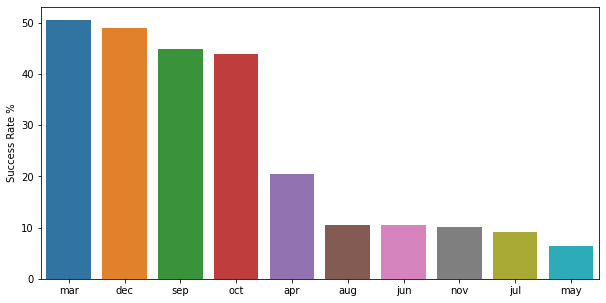

In [185]:
plt.figure(figsize = (10,5))
sns.barplot(y = percentMon['Success Rate %'], x = percentMon.index)

> <p style="font-family:'Courier New'">Kebanyakan Bank menawarkan nasabahnya di antara bulan Mei dan Agustus. Yang tertinggi di bulan Mei, namun sayangnya, di bulan Mei memiliki tingkat kesuksesan terendah. Tingkat kesuksesan tertinggi berada di bulan Maret dan kedua di bulan Desember. Artinya, adanya kesalahan strategi waktu dalam menelfon nasabah. 

> <p style="font-family:'Courier New'">Menurut artikel [1], musim semi di Portugal terjadi di antara bulan maret dan mei. Sedangkan untuk juni sampai agustus adalah musim panas. Menurut artikel [1] juga, pada bulan Mei, Portugal memiliki banyak acara-acara dan festival penting. 

> <p style="font-family:'Courier New'">Analisa saya, saat bulan mei, orang-orang sedang-sedangnya memikirkan festival-festival dan acara-acara penting lainnya yang akan terjadi di bulan Mei. Dimana artinya, orang-orang Portugal tidak punya waktu untuk memikirkan melakukan deposito atau tidak. 

> <p style="font-family:'Courier New'"><i> Rekomendasi: <br> Perbanyak menelfon nasabah diluar bulan mei dan agustus. Bulan maret harusnya menjadi bulan terbaik untuk menelfon para nasabah.
    
[1] https://www.audleytravel.com/us/portugal/best-time-to-visit?tab=mar-may

### campaign

<p style="font-family:'Courier New'">Fitur campaign memperlihatkan berapa banyak pengontakan terjadi pada kampanye kali ini. 

In [107]:
pd.crosstab(bank_clean['y'], bank_clean['campaign'], normalize = True)

campaign,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,39,40,41,42,43,56
y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
no,0.372487,0.227226,0.115738,0.058318,0.035909,0.021948,0.014349,0.009299,0.006458,0.005171,0.004006,0.002962,0.002137,0.001651,0.001190,0.001238,0.001311,0.000801,0.000631,0.000728,0.000583,0.000413,0.000364,0.000364,0.000194,0.000194,0.000267,0.000194,0.000243,0.00017,0.00017,0.000097,0.000097,0.000073,0.000121,0.000024,0.000024,0.000049,0.000024,0.000049,0.000049,0.000024
yes,0.055842,0.029402,0.013936,0.006045,0.002913,0.001821,0.000923,0.000413,0.000413,0.000291,0.000291,0.000073,0.000097,0.000024,0.000049,0.000000,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


> <p style="font-family:'Courier New'">Saya melakukan normalisasi agar lebih terlihat perubahannya, dimana dapat dilihat bahwa orang yang melakukan deposito jadi lebih kecil dan terus mengecil setelah campaign ke-6.

In [108]:
campaignSuccess = []
total = []

for i in bank_clean['campaign'].unique():
    campaignSuccess.append(100 * len(bank_clean[(bank_clean['campaign'] == i) & (bank_clean['y'] == 'yes')])
                  /len(bank_clean[bank_clean['campaign'] == i]))
    total.append(len(bank_clean[bank_clean['campaign'] == i]))
    
campaigndf = pd.DataFrame({'Success Rate %' : campaignSuccess, 
              'nth contact' : bank_clean['campaign'].unique(),
             'Total' : total}).sort_values(by = 'Success Rate %', ascending = False)
campaigndf

,Success Rate %,nth contact,Total
0,13.037071,1,17642
1,11.456954,2,10570
2,10.747051,3,5341
3,9.392682,4,2651
5,7.660878,6,979
4,7.504690,5,1599
20,6.896552,17,58
10,6.779661,11,177
15,6.250000,23,16
6,6.041335,7,629


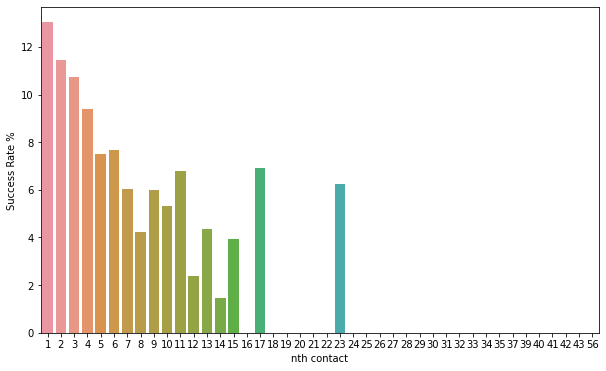

In [109]:
plt.figure(figsize = (10,6))
sns.barplot(x = campaigndf['nth contact'], y = campaigndf['Success Rate %'])

> <p style="font-family:'Courier New'"><i>Rekomendasi:<br> Berhenti di kontak ke-6, karena setelah kontak ke-6 sudah tidak terlalu tinggi success ratenya. Dapat dilihat pada kontak ke-7 dan ke-8. Memiliki jumlah pengontakan yang banyak, namun success ratenya tidak terlalu tinggi. </i>

### pdays and poutcome

<p style="font-family:'Courier New'">Fitur pdays memperlihatkan banyaknya hari yang terlewat setelah kampanye terakhir dilakukan. Sedangkan untuk fitur poutcome, menunjukkan hasil nasabah dari tawaran kampanye sebelumnya. 

In [110]:
percentP = []

for i in bank_clean['pdays'].unique():
    len_y = len(bank_clean[(bank_clean['y'] == 'yes') & (bank_clean['pdays'] == i)])
    percentP.append((len_y/len(bank_clean[bank_clean['pdays'] == i]))*100)
    
percentP = pd.DataFrame(data = percentP, index = bank_clean['pdays'].unique(), columns = ['Success Rate %']).sort_values(by = 'Success Rate %', ascending = False)
percentP['Total'] = bank_clean['pdays'].value_counts()
percentP

,Success Rate %,Total
Contacted,63.828383,1515
Never contacted before,9.258186,39673


In [111]:
percentPout = []

for i in bank_clean['poutcome'].unique():
    len_y = len(bank_clean[(bank_clean['y'] == 'yes') & (bank_clean['poutcome'] == i)])
    percentPout.append((len_y/len(bank_clean[bank_clean['poutcome'] == i]))*100)
    
percentPout = pd.DataFrame(data = percentPout, index = bank_clean['poutcome'].unique(), columns = ['Success Rate %']).sort_values(by = 'Success Rate %', ascending = False)
percentPout['Total'] = bank_clean['poutcome'].value_counts()
percentPout

,Success Rate %,Total
success,65.112891,1373
failure,14.228598,4252
nonexistent,8.832213,35563


## social and economics Features

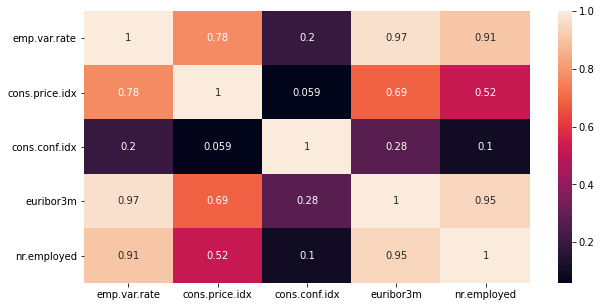

In [112]:
plt.figure(figsize = (10,5))
sns.heatmap(bank_clean[['emp.var.rate','cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']].corr(), annot = True)

> <p style="font-family:'Courier New'">Seperti yang sempat saya singgung di atas, bahwa social-economics features saling berkorelasi sangat kuat. Terutama untuk fitur <i>euribor3m</i> dengan <i>employment variation rate</i>. Ada baiknya, nanti saya akan lakukan plot untuk kedua fitur tersebut.

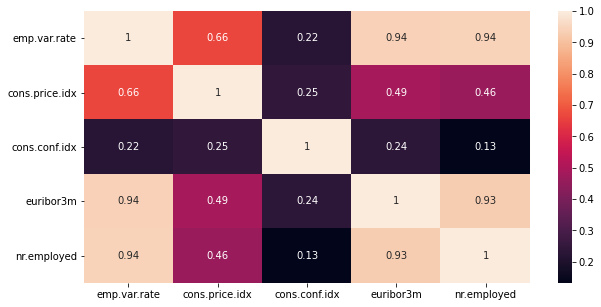

In [113]:
plt.figure(figsize = (10,5))
sns.heatmap(bank_clean[['emp.var.rate','cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']].corr('spearman'), annot = True)

> <p style="font-family:'Courier New'">Ternyata nilainya tidak jauh berbeda dan lebih besar di korelasi Pearson. Artinya fitur-fitur socio economics lebih berkorelasi secara linier daripada non-linier.

### euribor3m

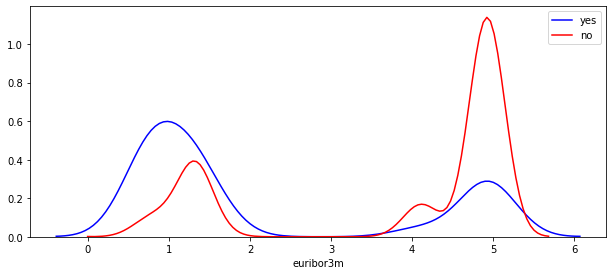

In [114]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
sns.distplot(bank_clean[bank_clean['y'] == 'yes']['euribor3m'], ax = ax, label = 'yes', hist = False, color = 'b')
sns.distplot(bank_clean[bank_clean['y'] == 'no']['euribor3m'], ax = ax, label = 'no', hist = False, color = 'r')
plt.legend()

> <p style="font-family:'Courier New'">Dari gambar di atas, terlihat terdapat cut-off yaitu di titik 3.<br> 


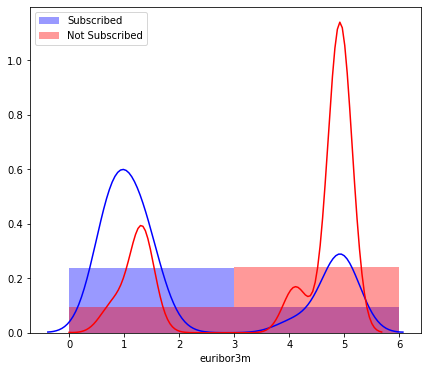

In [178]:
plt.figure(figsize = (7,6))

sns.distplot(bank_clean[bank_clean['y'] == 'yes']['euribor3m'], bins = [0, 3, 6], color = 'b', label = 'Subscribed')
sns.distplot(bank_clean[bank_clean['y'] == 'no']['euribor3m'], bins = [0, 3, 6], color = 'r', label = 'Not Subscribed')

plt.legend()

> <p style="font-family:'Courier New'">Sebenarnya dari gambar-gambar di atas sudah terlihat bahwa ketika euribor3m di bawah 3, nasabah berpeluang lebih besar untuk melakukan deposito, dan untuk di atas 3 nasabah berpeluang lebih besar untuk tidak melakukan deposito. Namun untuk memastikannya, saya akan menghitung luas distribusinya. 

In [116]:
bank_yes = bank_clean[bank_clean['y'] == 'yes']
bank_no = bank_clean[bank_clean['y'] == 'no']

field = 'euribor3m'
data_yes = np.array(bank_yes['%s'%field]).reshape(-1, 1)
data_no = np.array(bank_no['%s'%field]).reshape(-1, 1)

kd_yes = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_yes)
kd_no = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_no)

In [176]:
print('peluang nasabah melakukan deposito saat euribor3m di bawah tiga: {}'.format(get_probability(0,3,100,kd_yes)))

peluang nasabah melakukan deposito saat euribor3m di bawah tiga: 0.6876


In [177]:
print('peluang nasabah melakukan deposito saat euribor3m di atas tiga: {}'.format(get_probability(3,6,100,kd_yes)))

peluang nasabah melakukan deposito saat euribor3m di atas tiga: 0.2843


> <p style="font-family:'Courier New'">Peluang nasabah melakukan deposito lebih tinggi saat euribor sedang di bawah tiga. 

> <p style="font-family:'Courier New'">Perlu saya katakan bahwa saya bukan seseorang yang ahli di bidang ini, namun dari beberapa artikel-artikel yang saya baca, bank menggunakan euribor (dalam kasus ini untuk zone Eropa) untuk menentukan harga atau suku bunga dari suatu jenis produk keuangan, misalnya deposito jangka pendek atau suku bunga pinjaman. Jadi ketika euribor rendah artinya suku bunga pada pinjaman akan menurun, begitu juga dengan suku bunga di deposito. Maka seharusnya nasabah tidak melakukan deposito saat euribor rendah. Tetapi hasil yang didapatkan, berbeda, justru saat Euribor rendah, peluang seseorang melakukan deposito membesar. 

> <p style="font-family:'Courier New'">Dugaan saya, 'kejanggalan' ini terjadi dikarenakan faktor umur seseorang, yang dimana seperti telah disinggung sebelumnya, bahwa orang-orang berumur di bawah 30 tahun tidak memiliki wawasan atau pengetahuan tentang investasi deposito ini. Jadi mari kita coba lihat hubungan antara <i> age, euribor3m,</i> dan y. 

In [119]:
df_euribor_age = pd.concat([ageGroup, bank_clean['euribor3m'], bank_clean['y']], axis = 1)

In [120]:
df_euribor_age.groupby(['age','y']).mean()

euribor3m
age   y             
30-39 no    3.778910
      yes   2.354406
40-59 no    4.058558
      yes   2.431545
60+   no    3.149836
      yes   1.265327
<30   no    3.397332
      yes   1.726217

> <p style="font-family:'Courier New'">Hasil di atas menunjukkan, orang-orang yang berumur di bawah 30 tahun dan di atas 60 tahun, mereka melakukan deposito saat euribor3m sedang rendah-rendahnya (dikisaran satu koma). Namun sayangnya, hasil di atas tidak membuktikan dugaan di atas benar. 

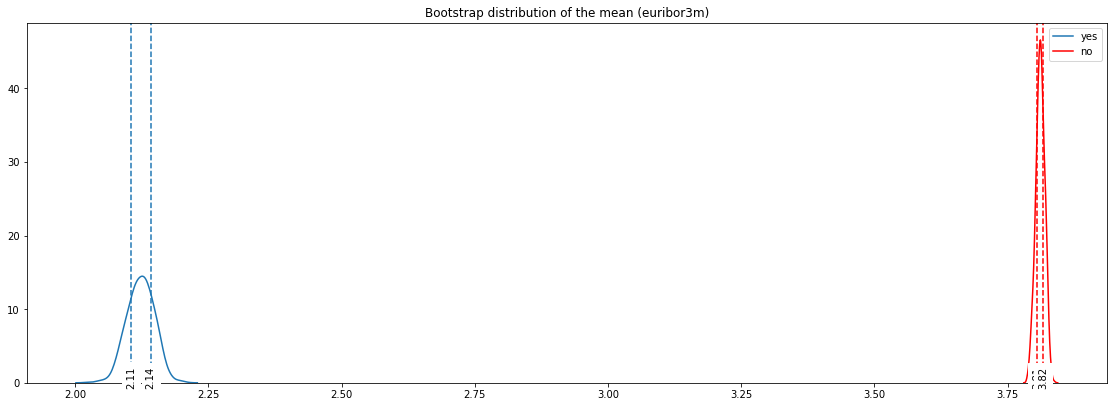

In [121]:
clt('euribor3m')

><p style="font-family:'Courier New'">Distribusi boostrap pada euribor di atas menunjukkan bahwa adanya perbedaan yang signifikan antara orang yang melakukan deposito atau tidak. Dan gambar di atas juga menunjukkan bahwa orang-orang melakukan deposito saat euribor3m sedang kecil-kecilnya. 

><p style="font-family:'Courier New'"><i> Rekomendasi:<br>
Hubungi dan tawarkan deposito ke nasabah saat euribor sedang rendah-rendahnya. Namun ada baiknya, jika tim telemarketing bertanya atau berdiskusi terlebih dulu ke ahlinya, atau mencari tahu bagaimana hubungan euribor dengan keputusan seseorang ingin melakukan deposito atau tidak</i>

> <p style="font-family:'Courier New'">Berhubung fitur euribor3m dan emp.var.rate memiliki korelasi yang tinggi, saya akan mencoba untuk melakukan scatterplot ke keduanya.

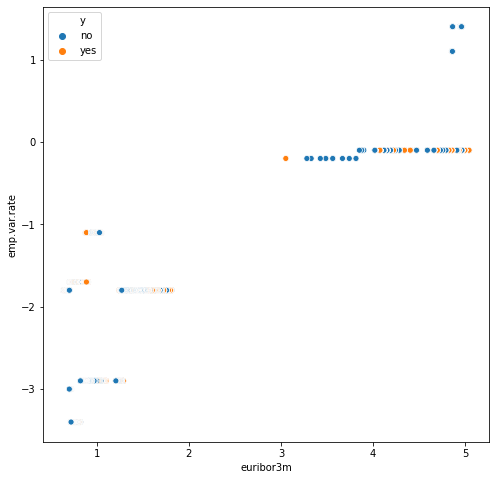

In [122]:
plt.figure(figsize = (8,8))
sns.scatterplot(bank_clean['euribor3m'], bank_clean['emp.var.rate'], hue = bank_clean['y'])

> <p style="font-family:'Courier New'">Sebetulnya dari visualisasi di atas dapat terlihat adanya empat kluster (empat keadaan socio-economics) di dalamnya. Namun sayangnya, karena saya bukan ahli di bidang ini, ada baiknya saya tetap membiarkannya seperti ini. Mungkin visualisasi di atas akan sangat berguna untuk orang-orang yang ahli di bidang ini. 

### cons.conf.idx (Consumer Confidence Index)

<p style="font-family:'Courier New'"> Menurut dari sumber-sumber [1] yang saya baca, <i> Consumer Confidence Index </i> itu memperlihatkan seberapa optimis atau pesimisnya seorang konsumen dalam mengeluarkan uangnya, semakin kecil indeksnya semakin kecil juga seseorang ingin mengeluarkan uangnya. Biasanya ukuran-ukuran ini didapat dari sebuah survey. 
    
[1] https://www.investopedia.com/terms/c/cci.asp

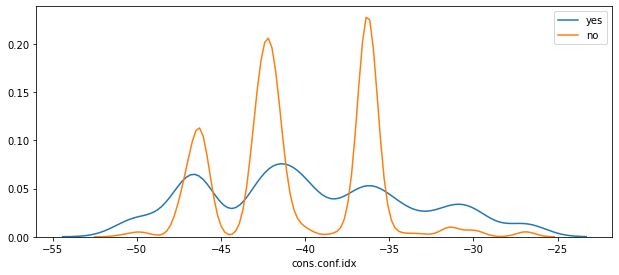

In [123]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
sns.distplot(bank[bank_clean['y'] == 'yes']['cons.conf.idx'], ax = ax, label = 'yes', hist = False)
sns.distplot(bank[bank_clean['y'] == 'no']['cons.conf.idx'], ax = ax, label = 'no', hist = False)
plt.legend()

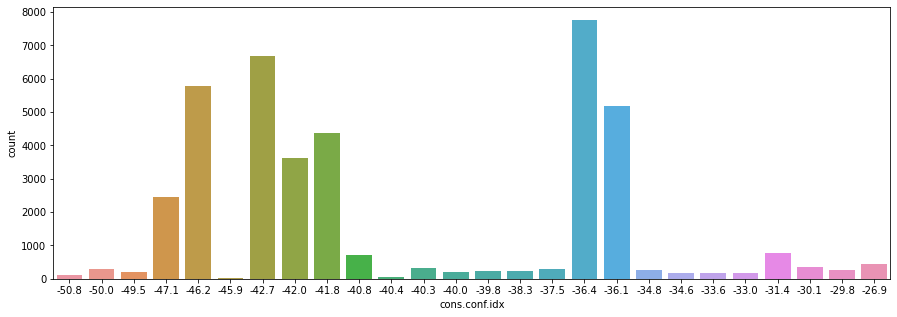

In [124]:
plt.figure(figsize = (15,5))
sns.countplot(bank_clean['cons.conf.idx'])

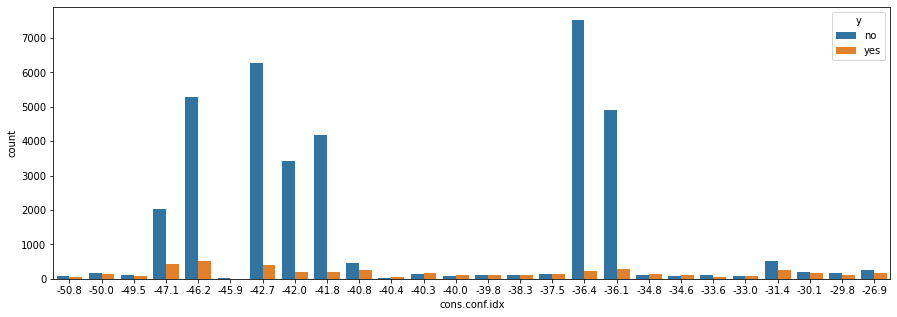

In [125]:
plt.figure(figsize = (15,5))
sns.countplot(bank_clean['cons.conf.idx'], hue = bank_clean['y'])

> <p style="font-family:'Courier New'">Terlihat di indeks -36.4 adalah indeks tertinggi banyaknya nasabah yang menolak untuk melakukan deposito, itu wajar terjadi dikarenakan memang kontak terjadi paling banyak di indeks itu. Jadi ada kemungkinan, adanya salah strategi dalam melakukan pengontakan, karena kemungkinan pengontakan terjadi tanpa melihat <i> Consumer Confidence Index </i> sebelumnya. 

> <p style="font-family:'Courier New'"> Sepertinya, bukan ide yang bagus buat mengontak nasabah di keadaan indeks kepercayaan yang lagi rendah-rendahnya. Dikarenakan kondisi masyarakat dalam kondisi pesimis untuk mengeluarkan uangnya.

In [173]:
max_ = abs(bank_clean['cons.conf.idx'].describe()['max'])
min_ = abs(bank_clean['cons.conf.idx'].describe()['min'])
center = ((max_ + min_)/2 )*-1
center

-38.849999999999994

> <p style="font-family:'Courier New'">Dikarenakan saya tidak melihat adanya sebuah titik potong. Saya mencoba menggunakan titik tengahnya sbagai titik potong dari menghitung peluang.

In [127]:
bank_yes = bank_clean[bank_clean['y'] == 'yes']

field = 'cons.conf.idx'
data_yes_conf = np.array(bank_yes['%s'%field]).reshape(-1, 1)
kd_yes_conf = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_yes_conf)

In [174]:
print('Peluang nasabah melakukan deposito dari cons.conf.idx -50.8 ke cons.conf.idx -38.85 adalah {}'.format(get_probability(-50.8,center, 100, kd_yes_conf)))

Peluang nasabah melakukan deposito dari cons.conf.idx -50.8 ke cons.conf.idx -38.85 adalah 0.5873


In [175]:
print('Peluang nasabah melakukan deposito dari cons.conf.idx -38.85 ke cons.conf.idx -26.9 adalah {}'.format(get_probability(center,-26.9, 100, kd_yes_conf)))

Peluang nasabah melakukan deposito dari cons.conf.idx -38.85 ke cons.conf.idx -26.9 adalah 0.3904


> <p style="font-family:'Courier New'">Terlihat bahwa peluang nasabah untuk melakukan deposito lebih besar saat cons.conf.idx sedang kecil. 

> <p style="font-family:'Courier New'"><i> Saran: Lakukan penawaran deposito saat indeks kepercayaan konsumen lagi rendah-rendahnya. Kemudian ada baiknya lagi, tim marketing bekerja sama dengan ahli di bidang ini, ahli yang dapat memprediksi kemana arah indeks kepercayaan konsumen. Jadi pihak bank dapat mengatur strategi lebih jauh.</i>

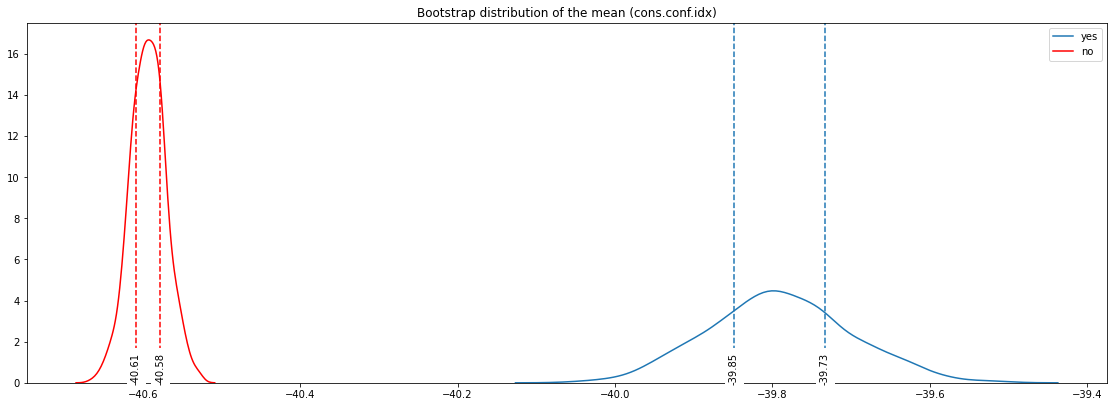

In [130]:
clt('cons.conf.idx')

> <p style="font-family:'Courier New'">Menariknya bootstrap distribution mengatakan yang berbeda. Menurut visualisasi di atas, orang-orang condong melakukan deposito saat cons.conf.idx saat sedang tinggi-tingginya. Seharusnya ada penjelasan lebih dalam tentang hal ini. 

### cons.price.idx

<p style="font-family:'Courier New'"> Menurut dari artikel-artikel [1,2] yang saya baca, <i> Consumer Price Index (CPI)</i> itu memperlihatkan perubahan harga suatu 'paket' barang dan jasa yang dikonsumsi oleh rumah tangga dalam periode waktu tertentu.
    
[1] https://macroeconomicdashboard.feb.ugm.ac.id/inflasi-dan-indeks-harga-konsumen/ <br>
[2] https://www.bps.go.id/subject/3/inflasi.html

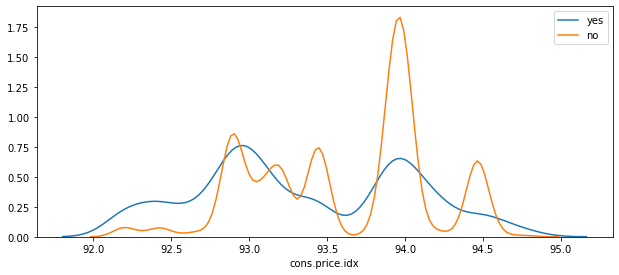

In [131]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
sns.distplot(bank[bank_clean['y'] == 'yes']['cons.price.idx'], ax = ax, label = 'yes', hist = False)
sns.distplot(bank[bank_clean['y'] == 'no']['cons.price.idx'], ax = ax, label = 'no', hist = False)
plt.legend()

In [168]:
max_ = abs(bank_clean['cons.price.idx'].describe()['max'])
min_ = abs(bank_clean['cons.price.idx'].describe()['min'])
center = ((max_ + min_)/2 )
center

93.48400000000001

In [133]:
field = 'cons.price.idx'
consPrice_yes = np.array(bank_yes['%s'%field]).reshape(-1, 1)
consPrice_no = np.array(bank_no['%s'%field]).reshape(-1, 1)

In [134]:
kd_consPriceyes = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(consPrice_yes)
kd_consPriceno = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(consPrice_no)

In [169]:
print('Peluang nasabah melakukan deposito saat cons.price.idx di indeks 92 sampai 93.5 adalah {}'.format(get_probability(92, center, 100, kd_consPriceyes)))

Peluang nasabah melakukan deposito saat cons.price.idx di indeks 92 sampai 93.5 adalah 0.5187


In [170]:
print('Peluang nasabah melakukan deposito saat cons.price.idx di indeks 93.5 sampai 95 adalah {}'.format(get_probability(center, 95, 100, kd_consPriceyes)))

Peluang nasabah melakukan deposito saat cons.price.idx di indeks 93.5 sampai 95 adalah 0.418


> <p style="font-family:'Courier New'">Peluang nasabah melakukan deposito lebih tinggi saat cons.price.idx sedang kecil.

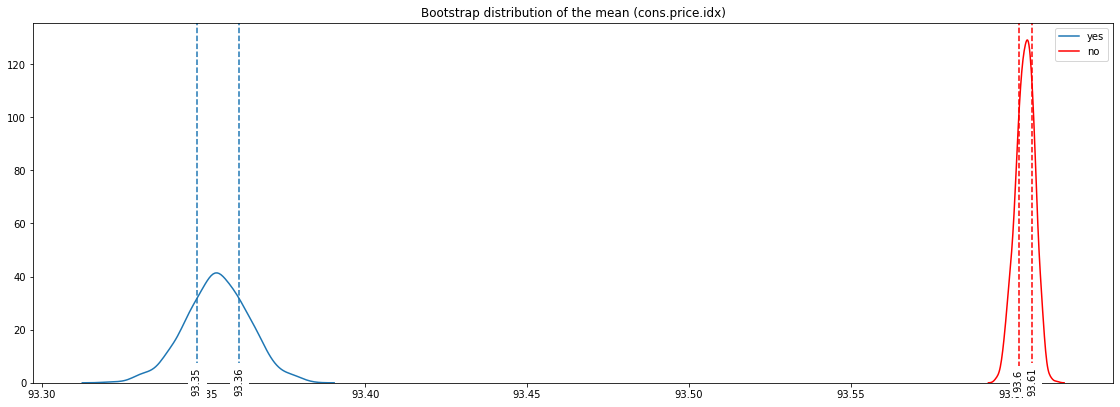

In [137]:
clt('cons.price.idx')

> <p style="font-family:'Courier New'">Bootstrap distribution juga sependapat dengan analisa di atas. Menurut saya juga, analisa dan visualisasi di atas cukup masuk akal. Dimana ketika harga-harga bahan pokok atau barang-barang rumah tangga sedang naik-naiknya, orang biasanya menolak untuk melakukan deposito. Karena orang-orang akan lebih memprioritaskan pengeluarannya ke bahan-bahan pokok terlebih dulu daripada melakukan deposito.

> <p style="font-family:'Courier New'">Rekomendasi: Lakukan penawaran ke nasabah saat indeks harga konsumen sedang rendah-rendahnya. Kemudian juga sama seperti rekomendasi lainnya di fitur ekonomi, ada baiknya jika tim telemarketing bekerja sama dengan ahli ekonomi atau ahli-ahli yang dapat memprediksi atau menebak kemana arah indeks harga konsumen ini. 

### nr.employed

> <p style="font-family:'Courier New'">Sebetulnya saya tidak mengerti fitur ini, jika merujuk dari penjelasan dataset yang di atas. Namun asumsi saya, fitur ini menunjukkan jumlah karyawan dari bank ini. 

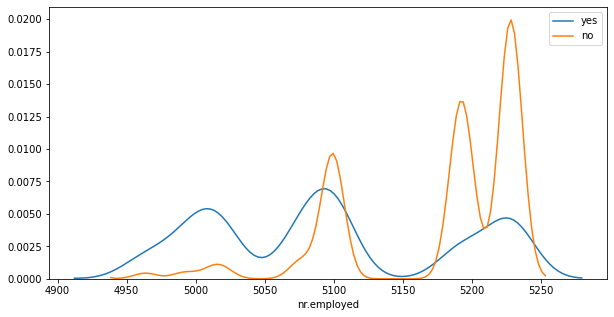

In [138]:
fig = plt.figure(figsize = (10,5))
sns.distplot(bank[bank_clean['y'] == 'yes']['nr.employed'], hist = False, label = 'yes')
sns.distplot(bank[bank_clean['y'] == 'no']['nr.employed'], hist = False, label = 'no')

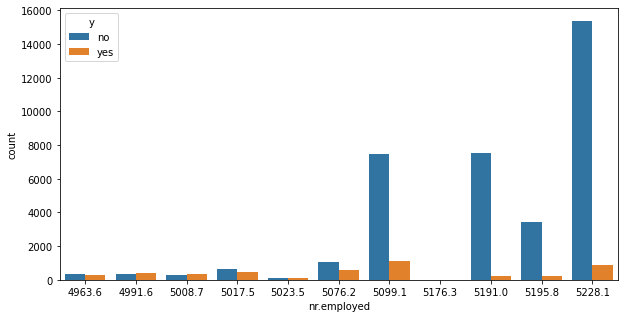

In [180]:
fig = plt.figure(figsize = (10,5))
sns.countplot(bank_clean['nr.employed'], hue = bank_clean['y'])

In [139]:
pd.crosstab(bank_clean['y'], bank_clean['nr.employed'])

nr.employed,4963.6,4991.6,5008.7,5017.5,5023.5,5076.2,5099.1,5176.3,5191.0,5195.8,5228.1
y,,,,,,,,,,,
no,334,370,281,617,84,1069,7442,9,7523,3451,15368
yes,301,403,369,454,88,594,1092,1,240,232,866


> <p style="font-family:'Courier New'">Cutoff berada di 5176.3

In [140]:
field = 'nr.employed'
nrEmployed_yes = np.array(bank_yes['%s'%field]).reshape(-1, 1)

kd_nrEmployed_yes = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(nrEmployed_yes)

In [167]:
print('Peluang nasabah melakukan deposito saat number of employees di antara 5176.3 dan 5228.1: {}'.format(get_probability(5176.2, 5228.2, 100, kd_nrEmployed_yes)))

Peluang nasabah melakukan deposito saat number of employees di antara 5176.3 dan 5228.1: 0.2469


In [179]:
print('Peluang nasabah melakukan deposito saat number of employees di antara 4963.6 dan 5176.3: {}'.format(get_probability(4963.1, 5176.2, 100, kd_nrEmployed_yes)))

Peluang nasabah melakukan deposito saat number of employees di antara 4963.6 dan 5176.3: 0.7182


> <p style="font-family:'Courier New'">Peluang nasabah melakukan deposito lebih tinggi saat number of employee sedang rendah. 

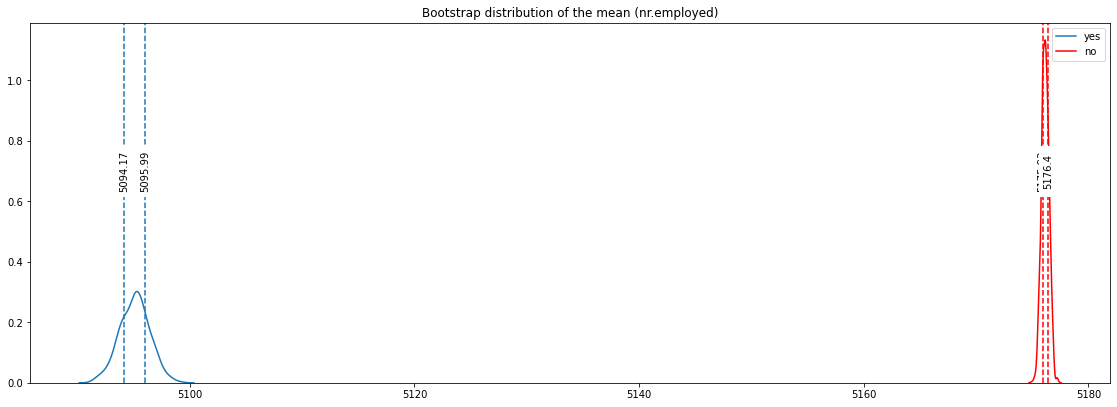

In [144]:
clt('nr.employed')

> <p style="font-family:'Courier New'">Bootstrap distribution juga setuju dengan analisa di atas, nasabah lebih memilih melakukan deposito saat number of employee sedang rendah-rendahnya. Sebetulnya visualisasi dan analisa di atas cukup menarik, ternyata nasabah lebih memilih melakukan deposito saat jumlah karyawan bank sedikit. Tapi tebakan saya, ada kemungkinan juga, saat jumlah karyawan bank sedikit. Bank menawarkan suku bunga deposito yang lebih tinggi ke nasabahnya.

> <p style="font-family:'Courier New'"><i>Rekomendasi: Lakukan penawaran deposito ke nasabah saat number of employee sedang rendah-rendahnya.</i> 

### emp.var.rate

<p style="font-family:'Courier New'">Sebetulnya saya tidak mendapatkan definisi yang jelas apa maksudnya dari fitur ini. Namun setelah saya melakukan eksplorasi di bawah, saya berasumsi bahwa ketika emp.var.rate minus, artinya jumlah karyawan menurun. Dan saat emp.var.rate positive artinya jumlah karyawan naik. Ini dapat dilihat dari visualisasi di bawah. 

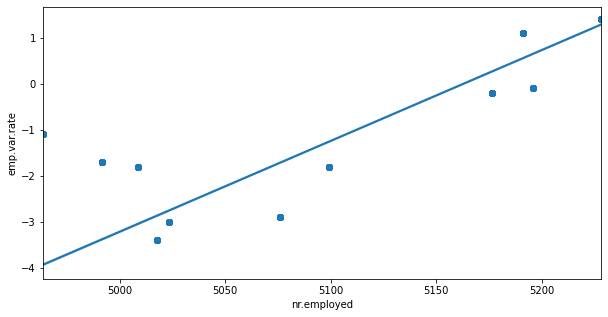

In [184]:
fig = plt.figure(figsize = (10,5))
sns.regplot(bank_clean['nr.employed'], bank_clean['emp.var.rate'])

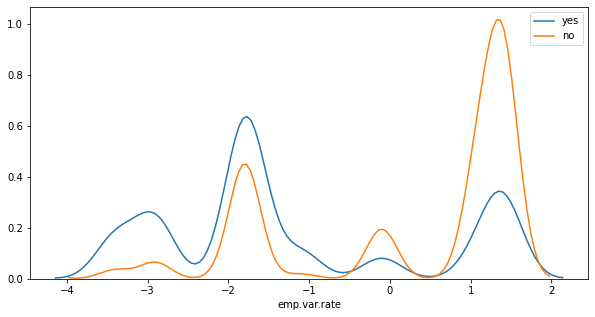

In [145]:
fig = plt.figure(figsize = (10,5))
sns.distplot(bank[bank_clean['y'] == 'yes']['emp.var.rate'], hist = False, label = 'yes')
sns.distplot(bank[bank_clean['y'] == 'no']['emp.var.rate'], hist = False, label = 'no')

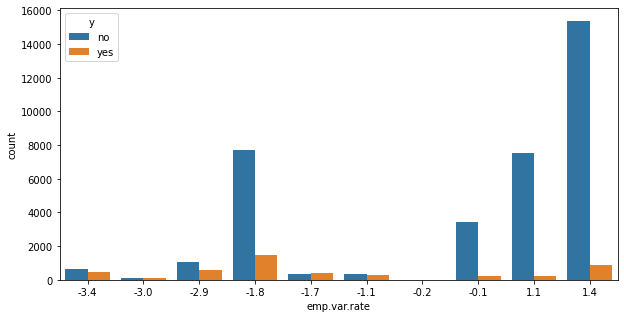

In [146]:
fig = plt.figure(figsize = (10,5))
sns.countplot(bank_clean['emp.var.rate'], hue = bank_clean['y'])

In [149]:
field = 'emp.var.rate'
varRate_yes = np.array(bank_yes['%s'%field]).reshape(-1, 1)

kd_varRate_yes = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(varRate_yes)

In [171]:
print('Peluang nasabah melakukan deposito saat emp.var.rate ada di antara -4 dan -1 adalah {}'.format(get_probability(-4, -1, 100, kd_varRate_yes)))

Peluang nasabah melakukan deposito saat emp.var.rate ada di antara -4 dan -1 adalah 0.6512


In [172]:
print('Peluang nasabah melakukan deposito saat emp.var.rate ada di antara -1 dan -2 adalah {}'.format(get_probability(-1, 2, 100, kd_varRate_yes)))

Peluang nasabah melakukan deposito saat emp.var.rate ada di antara -1 dan -2 adalah 0.3186


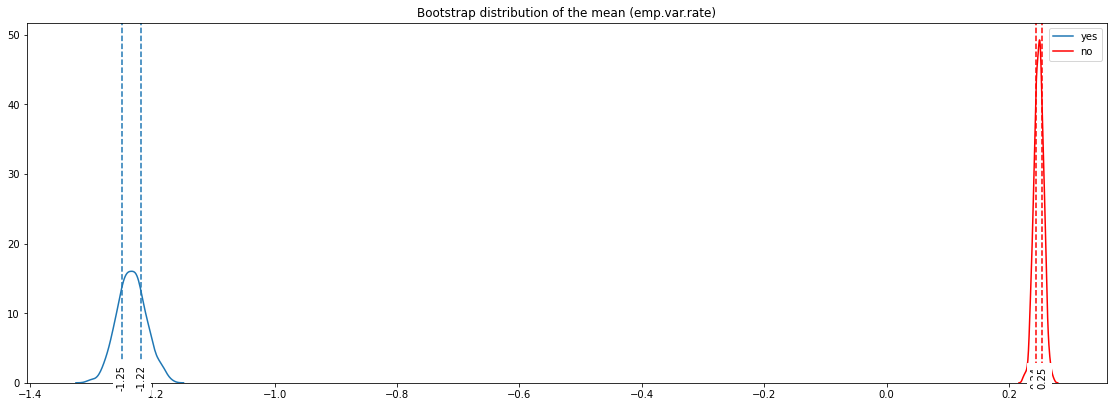

In [152]:
clt('emp.var.rate')

> <p style="font-family:'Courier New'">Dari visualisasi di atas dapat dilihat, orang-orang melakukan deposito saat <i>employment variation rate</i> minus. Boleh dibilang, fitur ini juga sependapat dengan fitur nr.employed sebelumnya. Orang-orang lebih memilih melakukan deposito saat jumlah karyawan menurun atau sedikit. 

> <p style="font-family:'Courier New'"><i>Rekomendasi: Lakukan penawaran deposito ke nasabah saat employment variation rate sedang minus atau saat sedang menurun.</i> 